# Multi-Stratified Ranking Analysis

**Dataset**: PXD037527 (Wide Window Acquisition)

**Metrics**: Hyperscore, MS2 intensity, FragShare, MS1 abundance, Prosit cosine

**Stratification**: Window category × Chimericity × Spectrum complexity

In [2]:
# ============================================================
# SETUP
# ============================================================
import os
os.environ['NUMBA_CACHE_DIR'] = '/tmp/numba_cache'
os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import pickle
import warnings
warnings.filterwarnings('ignore')

# Paths
PROJECT_DIR = Path('/data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0')
DATA_DIR = PROJECT_DIR / 'processed_data'
CACHE_DIR = PROJECT_DIR / 'cache'
PLOT_DIR = PROJECT_DIR / 'plots' / '05_ranking_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Config
USE_BIOSAUR = False  # Set True when Biosaur data available
COLORS = {'narrow': '#2ecc71', 'medium': '#f39c12', 'wide': '#e74c3c'}

plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
sns.set_style('whitegrid')

print(f"Project: {PROJECT_DIR}")
print(f"Plots: {PLOT_DIR}")
print(f"Biosaur: {'Enabled' if USE_BIOSAUR else 'Disabled'}")

Project: /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0
Plots: /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/plots/05_ranking_analysis
Biosaur: Disabled


---
## Annotation (SLURM)

In [3]:
# ============================================================
# ANNOTATION SUBMISSION (Run once, then skip)
# ============================================================
import subprocess

ANNOTATION_CACHE = CACHE_DIR / 'psm_annotated_final.csv'
SLURM_SCRIPT = CACHE_DIR / 'run_annotation.slurm'
PYTHON_SCRIPT = CACHE_DIR / 'annotation.py'
SHARED_DATA = CACHE_DIR / 'shared_data.pkl'

In [18]:
# ============================================================
# ANNOTATION SUBMISSION (Run once, then skip)
# ============================================================
import subprocess

ANNOTATION_CACHE = CACHE_DIR / 'psm_annotated_final.csv'
SLURM_SCRIPT = CACHE_DIR / 'run_annotation.slurm'
PYTHON_SCRIPT = CACHE_DIR / 'annotation.py'
SHARED_DATA = CACHE_DIR / 'shared_data.pkl'

# Skip if annotation exists
if ANNOTATION_CACHE.exists():
    print(f"✓ Annotation exists: {ANNOTATION_CACHE.stat().st_size/1e6:.1f} MB")
    print("Skipping annotation submission.")
else:
    print("Generating annotation scripts...")
    
    # ============================================================
    # Python annotation script (ORIGINALE)
    # ============================================================
    python_code = '''#!/usr/bin/env python
import os
os.environ['NUMBA_CACHE_DIR'] = '/tmp'

import numpy as np
import pandas as pd
import pickle
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import spectrum_utils.spectrum as sus

print("Loading data...")
with open('''' + str(SHARED_DATA) + '''', 'rb') as f:
    data = pickle.load(f)

psm = data['psm']
spectra_dict = data['spectra_dict']
prosit_cache = data['prosit_cache']

print(f"Loaded {len(psm):,} PSMs")

def cosine_similarity(mz1, int1, mz2, int2, tol_ppm=20):
    if len(mz1) == 0 or len(mz2) == 0:
        return 0.0
    int1_n = int1 / np.linalg.norm(int1)
    int2_n = int2 / np.linalg.norm(int2)
    dot = 0.0
    for m1, i1 in zip(mz1, int1_n):
        matches = np.where(np.abs(mz2 - m1) / m1 * 1e6 <= tol_ppm)[0]
        if len(matches) > 0:
            dot += i1 * int2_n[matches[0]]
    return dot

def annotate_spectrum(idx):
    row = psm.iloc[idx]
    
    mzml_name = row['mzml_name']
    if not mzml_name.endswith('.mzML'):
        mzml_name += '.mzML'
    
    key = (mzml_name, int(row['scan_number']))
    if key not in spectra_dict:
        return None
    
    obs = spectra_dict[key]
    mz_obs, int_obs = obs['mz'], obs['intensity']
    if len(mz_obs) == 0:
        return None
    
    peptide = row['Peptide']
    charge = int(row['Charge'])
    precursor_mz = row['Observed M/Z']
    
    result = {
        'spectrum_key': row['spectrum_key'],
        'Peptide': peptide,
        'Charge': charge,
        'Hyperscore': row['Hyperscore'],
        'window_mz': row['window_mz'],
        'window_category': row['window_category'],
        'is_chimeric': row['is_chimeric'],
        'n_psm': row['n_psm'],
        'n_peaks_total': len(mz_obs),
        'total_intensity': int_obs.sum()
    }
    
    try:
        spec = sus.MsmsSpectrum('t', precursor_mz, charge, mz_obs.copy(), int_obs.copy())
        spec.annotate_proforma(peptide, 20, 'ppm', ion_types='by', 
                               neutral_losses=False, max_ion_charge=charge)
        mask = np.array([a is not None and str(a).startswith(('b','y')) for a in spec.annotation])
        mz_by, int_by = mz_obs[mask], int_obs[mask]
        
        result['by_n_peaks'] = len(mz_by)
        result['by_int_sum'] = int_by.sum()
        result['by_int_frac'] = int_by.sum() / int_obs.sum() if int_obs.sum() > 0 else 0
    except:
        mz_by, int_by = np.array([]), np.array([])
        result['by_n_peaks'] = 0
        result['by_int_sum'] = 0
        result['by_int_frac'] = 0
    
    prosit_key = (peptide, charge)
    if prosit_key in prosit_cache and len(mz_by) > 0:
        mz_p = prosit_cache[prosit_key]['mz']
        int_p = prosit_cache[prosit_key]['intensity']
        n_match = sum(1 for mp in mz_p if np.any(np.abs(mz_by - mp) / mp * 1e6 <= 20))
        
        result['prosit_n_ions'] = len(mz_p)
        result['prosit_n_matched'] = n_match
        result['prosit_match_rate'] = 100 * n_match / len(mz_p) if len(mz_p) > 0 else 0
        result['prosit_cosine'] = cosine_similarity(mz_by, int_by, mz_p, int_p)
    else:
        result['prosit_n_ions'] = 0
        result['prosit_n_matched'] = 0
        result['prosit_match_rate'] = 0
        result['prosit_cosine'] = 0
    
    return result

n_cores = cpu_count()
print(f"Using {n_cores} cores")

indices = list(range(len(psm)))

with Pool(n_cores) as pool:
    results = list(tqdm(pool.imap(annotate_spectrum, indices), total=len(indices)))

results = [r for r in results if r is not None]

df = pd.DataFrame(results)
df.to_csv('''' + str(ANNOTATION_CACHE) + '''', index=False)
print(f"\\nSaved {len(df):,} PSMs")
print(f"Mean b/y peaks: {df['by_n_peaks'].mean():.1f}")
print(f"Mean b/y fraction: {df['by_int_frac'].mean()*100:.1f}%")
'''
    
    with open(PYTHON_SCRIPT, 'w') as f:
        f.write(python_code)
    
    # ============================================================
    # SLURM submission script
    # ============================================================
    slurm_code = f'''#!/bin/bash
#SBATCH --job-name=annotate
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=64
#SBATCH --time=02:00:00
#SBATCH --mem=200G
#SBATCH --partition=zen2
#SBATCH --output={CACHE_DIR}/annotation_%j.out
#SBATCH --error={CACHE_DIR}/annotation_%j.err

export NUMBA_CACHE_DIR=/tmp
export PYTHONDONTWRITEBYTECODE=1

echo "Job ID: $SLURM_JOB_ID"
echo "Node: $SLURM_JOB_NODELIST"
echo "CPUs: $SLURM_CPUS_PER_TASK"

python {PYTHON_SCRIPT}

echo "Done at $(date)"
'''
    
    with open(SLURM_SCRIPT, 'w') as f:
        f.write(slurm_code)
    
    # ============================================================
    # Prepare shared data
    # ============================================================
    print("Preparing shared data...")
    
    psm = pd.read_csv(DATA_DIR / 'psm_clean.csv')
    
    with open(CACHE_DIR / 'spectra_dict.pkl', 'rb') as f:
        spectra_dict = pickle.load(f)
    
    with open(CACHE_DIR / 'prosit_cache.pkl', 'rb') as f:
        prosit_cache = pickle.load(f)
    
    with open(SHARED_DATA, 'wb') as f:
        pickle.dump({
            'psm': psm,
            'spectra_dict': spectra_dict,
            'prosit_cache': prosit_cache
        }, f)
    
    print(f"✓ Shared data saved: {SHARED_DATA.stat().st_size/1e6:.1f} MB")
    
    # ============================================================
    # Submit job
    # ============================================================
    result = subprocess.run(['sbatch', str(SLURM_SCRIPT)], 
                           capture_output=True, text=True)
    
    if result.returncode == 0:
        job_id = result.stdout.strip().split()[-1]
        print(f"\n✓ Job {job_id} submitted")
        print(f"\nMonitor:")
        print(f"  squeue -u $USER")
        print(f"  tail -f {CACHE_DIR}/annotation_*.err")
        print(f"\nExpected: ~1-1.5 hours")
    else:
        print(f"✗ Submission failed: {result.stderr}")

Generating annotation scripts...
Preparing shared data...
✓ Shared data saved: 4850.3 MB

✓ Job 3026847 submitted

Monitor:
  squeue -u $USER
  tail -f /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/cache/annotation_*.err

Expected: ~1-1.5 hours


In [3]:
# ============================================================
# CHECK ANNOTATION STATUS
# ============================================================
import time

print("Checking annotation status...\n")

# 1. Check if file exists
if ANNOTATION_CACHE.exists():
    try:
        df_test = pd.read_csv(ANNOTATION_CACHE)
        print(f"✓ Annotation complete: {len(df_test):,} PSMs")
        print(f"  File size: {ANNOTATION_CACHE.stat().st_size/1e6:.1f} MB")
        print(f"  Mean b/y peaks: {df_test['by_n_peaks'].mean():.1f}")
        print(f"  Mean b/y fraction: {df_test['by_int_frac'].mean()*100:.1f}%")
        print(f"  With Prosit: {(df_test['prosit_cosine']>0).sum():,} ({100*(df_test['prosit_cosine']>0).mean():.1f}%)")
    except Exception as e:
        print(f"⏳ File exists but can't read (still writing?): {e}")
else:
    print("✗ Annotation file not found\n")
    
    # 2. Check running jobs
    import subprocess
    result = subprocess.run(['squeue', '-u', os.environ.get('USER', 'vsc21150')], 
                           capture_output=True, text=True)
    
    if 'annotate' in result.stdout:
        print("✓ Job is running:")
        for line in result.stdout.split('\n'):
            if 'annotate' in line:
                print(f"  {line}")
    else:
        print("✗ No annotation job running")
    
    # 3. Check latest logs
    print("\n" + "="*60)
    print("LATEST LOGS")
    print("="*60)
    
    err_files = list(CACHE_DIR.glob('annotation_*.err'))
    out_files = list(CACHE_DIR.glob('annotation_*.out'))
    
    if err_files:
        latest_err = sorted(err_files, key=lambda x: x.stat().st_mtime)[-1]
        age_min = (time.time() - latest_err.stat().st_mtime) / 60
        
        print(f"\n.err file: {latest_err.name} ({age_min:.1f} min ago)")
        lines = latest_err.read_text().strip().split('\n')
        
        # Show progress if found
        progress = [l for l in lines if '%' in l or 'it/s' in l]
        if progress:
            print("Progress:")
            for line in progress[-5:]:  # Last 5 progress lines
                print(f"  {line}")
        
        # Show last 10 lines
        print("\nLast 10 lines:")
        for line in lines[-10:]:
            print(f"  {line}")
    
    if out_files:
        latest_out = sorted(out_files, key=lambda x: x.stat().st_mtime)[-1]
        age_min = (time.time() - latest_out.stat().st_mtime) / 60
        
        print(f"\n.out file: {latest_out.name} ({age_min:.1f} min ago)")
        lines = latest_out.read_text().strip().split('\n')
        
        print("Last 10 lines:")
        for line in lines[-10:]:
            print(f"  {line}")
    
    # 4. Monitor command
    print("\n" + "="*60)
    print("MONITOR COMMANDS")
    print("="*60)
    print(f"  squeue -u $USER")
    print(f"  tail -f {CACHE_DIR}/annotation_*.err")
    print(f"  watch -n 5 'tail -20 {CACHE_DIR}/annotation_*.err'")

Checking annotation status...

✓ Annotation complete: 1,132,669 PSMs
  File size: 242.6 MB
  Mean b/y peaks: 10.1
  Mean b/y fraction: 9.1%
  With Prosit: 1,131,648 (99.9%)


In [8]:
# ============================================================
# LOAD DATA
# ============================================================
print("Loading data...")

# PSM data
psm = pd.read_csv(DATA_DIR / 'psm_clean.csv')
print(f"PSM: {len(psm):,} rows")

# Annotated PSMs (already with neutral_losses=False)
df = pd.read_csv(CACHE_DIR / 'psm_annotated_final.csv')
print(f"Annotated: {len(df):,} PSMs")

# Merge missing columns
merge_cols = ['mzml_name', 'scan_number', 'Observed M/Z', 'Intensity', 'window_category']
missing = [c for c in merge_cols if c not in df.columns]
if missing:
    psm_subset = psm[['spectrum_key', 'Peptide'] + missing].drop_duplicates()
    df = df.merge(psm_subset, on=['spectrum_key', 'Peptide'], how='left', suffixes=('', '_x'))
    df = df[[c for c in df.columns if not c.endswith('_x')]]
    print(f"Merged {len(missing)} columns")

# Load caches
with open(CACHE_DIR / 'spectra_dict.pkl', 'rb') as f:
    spectra_dict = pickle.load(f)
with open(CACHE_DIR / 'prosit_cache.pkl', 'rb') as f:
    prosit_cache = pickle.load(f)

print(f"Spectra: {len(spectra_dict):,}")
print(f"Prosit: {len(prosit_cache):,}")

Loading data...
PSM: 1,276,641 rows
Annotated: 1,132,669 PSMs
Merged 4 columns
Spectra: 955,800
Prosit: 27,907


In [15]:
# ============================================================
# SPECTRUM-LEVEL AGGREGATION
# ============================================================
print("Spectrum-level aggregation...")

spectrum_summary = df.groupby('spectrum_key').agg({
    'is_chimeric': 'first',
    'n_psm': 'first',
    'window_category': 'first',
    'n_peaks_total': 'first',
    'total_intensity': 'first',
    'by_n_peaks': 'sum',
    'by_int_sum': 'sum'
}).reset_index()

spectrum_summary['by_peak_frac'] = spectrum_summary['by_n_peaks'] / spectrum_summary['n_peaks_total']
spectrum_summary['by_int_frac'] = spectrum_summary['by_int_sum'] / spectrum_summary['total_intensity']

print(f"Spectra: {len(spectrum_summary):,}")
print(f"  Non-chimeric: {(~spectrum_summary['is_chimeric']).sum():,}")
print(f"  Chimeric: {spectrum_summary['is_chimeric'].sum():,}")

spectrum_summary.to_csv(CACHE_DIR / 'spectrum_summary.csv', index=False)

Spectrum-level aggregation...
Spectra: 611,377
  Non-chimeric: 296,582
  Chimeric: 314,795


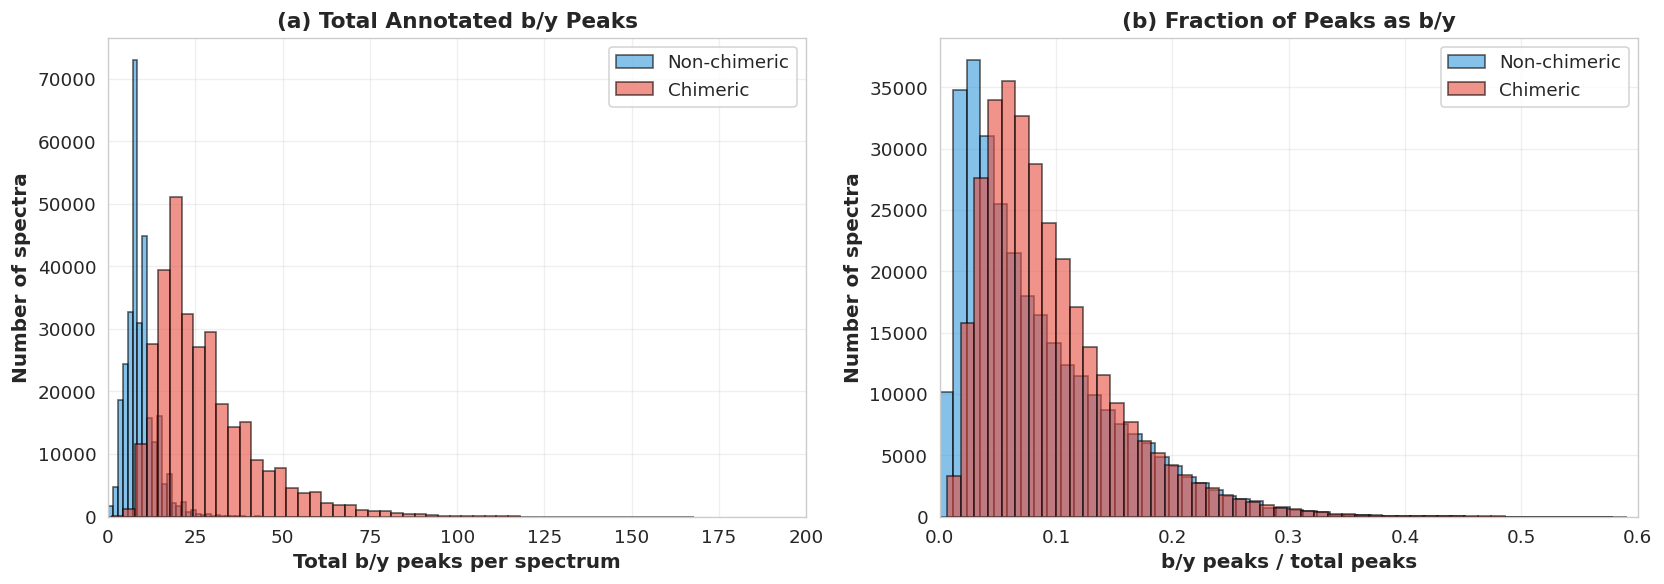

In [7]:
# ============================================================
# PLOT: b/y Peaks Distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Total b/y peaks per spectrum
axes[0].hist(spectrum_summary[~spectrum_summary['is_chimeric']]['by_n_peaks'], 
            bins=50, alpha=0.6, label='Non-chimeric', color='#3498db', 
            edgecolor='black')
axes[0].hist(spectrum_summary[spectrum_summary['is_chimeric']]['by_n_peaks'], 
            bins=50, alpha=0.6, label='Chimeric', color='#e74c3c', 
            edgecolor='black')
axes[0].set_xlabel('Total b/y peaks per spectrum', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of spectra', fontsize=12, fontweight='bold')
axes[0].set_title('(a) Total Annotated b/y Peaks', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].set_xlim(0, 200)
axes[0].grid(alpha=0.3)

# (b) Fraction of peaks as b/y
axes[1].hist(spectrum_summary[~spectrum_summary['is_chimeric']]['by_peak_frac'], 
            bins=50, alpha=0.6, label='Non-chimeric', color='#3498db', 
            edgecolor='black')
axes[1].hist(spectrum_summary[spectrum_summary['is_chimeric']]['by_peak_frac'], 
            bins=50, alpha=0.6, label='Chimeric', color='#e74c3c', 
            edgecolor='black')
axes[1].set_xlabel('b/y peaks / total peaks', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of spectra', fontsize=12, fontweight='bold')
axes[1].set_title('(b) Fraction of Peaks as b/y', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].set_xlim(0, 0.6)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / '01_by_peaks_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

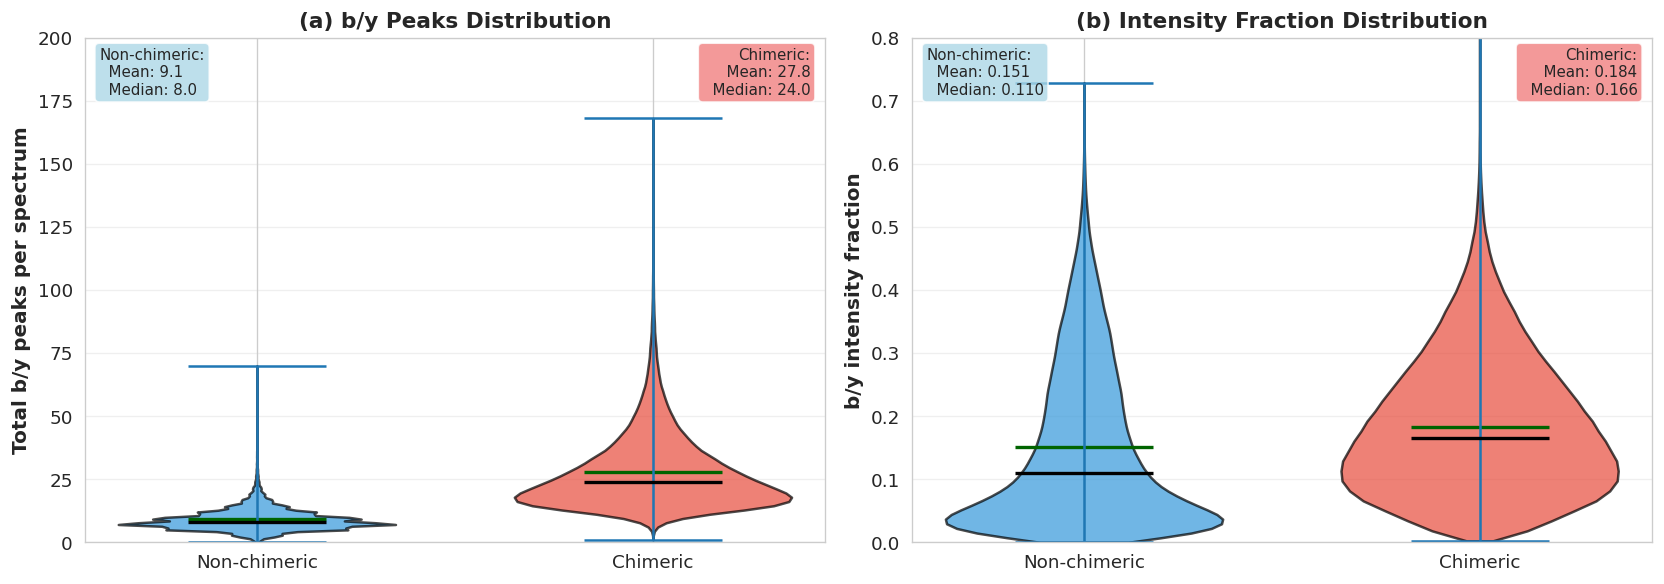

In [8]:
# ============================================================
# PLOT: Violin Plots (b/y peaks & intensity fraction)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

non_chim = spectrum_summary[~spectrum_summary['is_chimeric']]
chim = spectrum_summary[spectrum_summary['is_chimeric']]

# (a) b/y peaks
parts1 = axes[0].violinplot([non_chim['by_n_peaks'], chim['by_n_peaks']],
                            positions=[1, 2], widths=0.7, showmeans=True, showmedians=True)

for pc, color in zip(parts1['bodies'], ['#3498db', '#e74c3c']):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

parts1['cmedians'].set_color('black')
parts1['cmedians'].set_linewidth(2)
parts1['cmeans'].set_color('darkgreen')
parts1['cmeans'].set_linewidth(2)

axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Non-chimeric', 'Chimeric'], fontsize=11)
axes[0].set_ylabel('Total b/y peaks per spectrum', fontsize=12, fontweight='bold')
axes[0].set_title('(a) b/y Peaks Distribution', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 200)
axes[0].grid(axis='y', alpha=0.3)

# Stats text
axes[0].text(0.02, 0.98, 
            f'Non-chimeric:\n  Mean: {non_chim["by_n_peaks"].mean():.1f}\n  Median: {non_chim["by_n_peaks"].median():.1f}',
            transform=axes[0].transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[0].text(0.98, 0.98, 
            f'Chimeric:\n  Mean: {chim["by_n_peaks"].mean():.1f}\n  Median: {chim["by_n_peaks"].median():.1f}',
            transform=axes[0].transAxes, fontsize=9, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# (b) b/y intensity fraction
parts2 = axes[1].violinplot([non_chim['by_int_frac'], chim['by_int_frac']],
                            positions=[1, 2], widths=0.7, showmeans=True, showmedians=True)

for pc, color in zip(parts2['bodies'], ['#3498db', '#e74c3c']):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

parts2['cmedians'].set_color('black')
parts2['cmedians'].set_linewidth(2)
parts2['cmeans'].set_color('darkgreen')
parts2['cmeans'].set_linewidth(2)

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Non-chimeric', 'Chimeric'], fontsize=11)
axes[1].set_ylabel('b/y intensity fraction', fontsize=12, fontweight='bold')
axes[1].set_title('(b) Intensity Fraction Distribution', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, 0.8)
axes[1].grid(axis='y', alpha=0.3)

# Stats text
axes[1].text(0.02, 0.98, 
            f'Non-chimeric:\n  Mean: {non_chim["by_int_frac"].mean():.3f}\n  Median: {non_chim["by_int_frac"].median():.3f}',
            transform=axes[1].transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[1].text(0.98, 0.98, 
            f'Chimeric:\n  Mean: {chim["by_int_frac"].mean():.3f}\n  Median: {chim["by_int_frac"].median():.3f}',
            transform=axes[1].transAxes, fontsize=9, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))



plt.tight_layout()
plt.savefig(PLOT_DIR / '02_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()

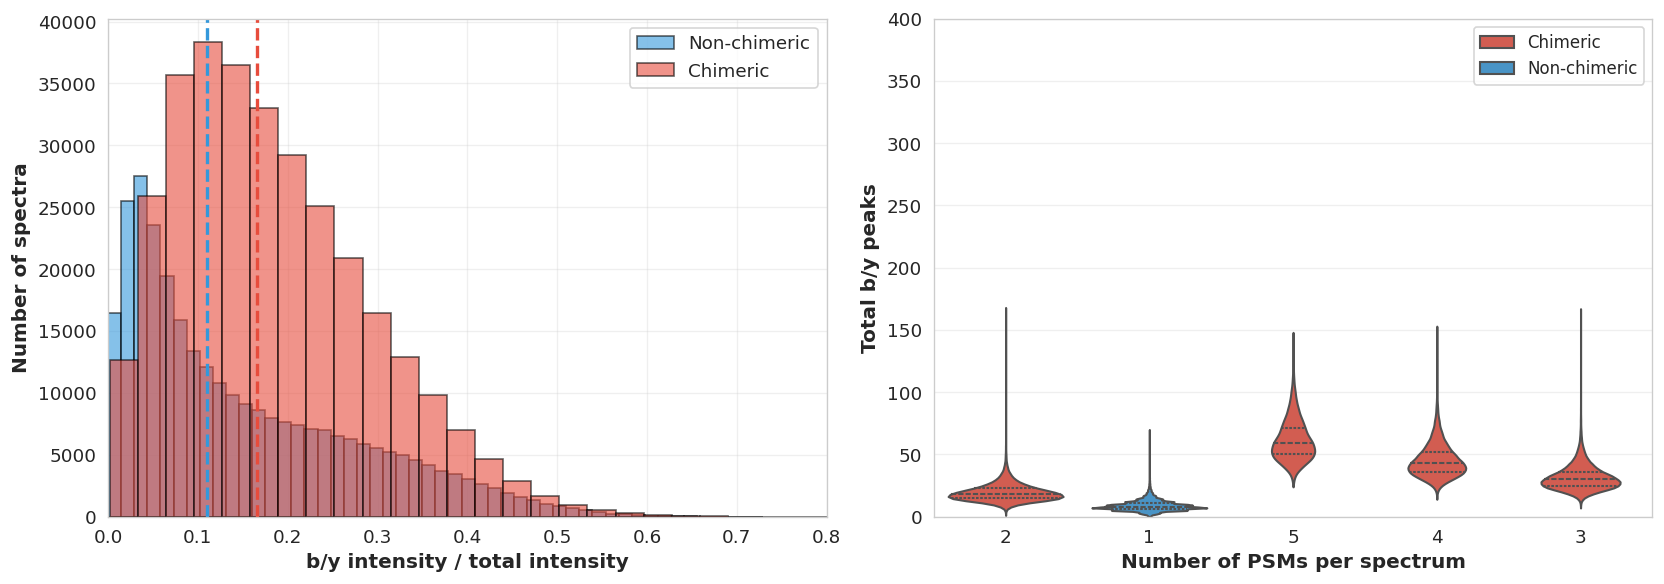

In [14]:
# ============================================================
# PLOT: b/y Peaks by Spectrum Complexity
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Intensity fraction distribution — FRACTION OF SPECTRA PER GROUP
bins = np.linspace(0, 0.8, 51)

w_non = np.ones(len(non_chim)) / len(non_chim)
w_chim = np.ones(len(chim)) / len(chim)

# (a) Intensity fraction distribution — COUNTS
axes[0].hist(non_chim['by_int_frac'], bins=50, alpha=0.6,
             label='Non-chimeric', color='#3498db', edgecolor='black')
axes[0].hist(chim['by_int_frac'], bins=50, alpha=0.6,
             label='Chimeric', color='#e74c3c', edgecolor='black')

axes[0].axvline(non_chim['by_int_frac'].median(), color='#3498db',
                linestyle='--', lw=2)
axes[0].axvline(chim['by_int_frac'].median(), color='#e74c3c',
                linestyle='--', lw=2)

axes[0].set_xlabel('b/y intensity / total intensity', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of spectra', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].set_xlim(0, 0.8)
axes[0].grid(alpha=0.3)


# (b) b/y peaks vs n_psm (violin plot)
plot_data = spectrum_summary[spectrum_summary['n_psm'] <= 10].copy()
plot_data['n_psm_cat'] = plot_data['n_psm'].astype(str)
plot_data['Chimericity'] = plot_data['is_chimeric'].map({False: 'Non-chimeric', True: 'Chimeric'})

import seaborn as sns
sns.violinplot(data=plot_data, x='n_psm_cat', y='by_n_peaks',
               hue='Chimericity',
               palette={'Non-chimeric': '#3498db', 'Chimeric': '#e74c3c'},
               split=False, ax=axes[1], inner='quartile', cut=0)

axes[1].set_xlabel('Number of PSMs per spectrum', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total b/y peaks', fontsize=12, fontweight='bold')
axes[1].legend(title='', fontsize=10)
axes[1].set_ylim(0, 400)
axes[1].grid(axis='y', alpha=0.3)

# Linear fit for chimeric
chimeric_means = plot_data[plot_data['is_chimeric']].groupby('n_psm')['by_n_peaks'].mean()
if len(chimeric_means) > 2:
    from scipy import stats as sp_stats
    x_fit = chimeric_means.index.values
    y_fit = chimeric_means.values
    slope, intercept, r_value, _, _ = sp_stats.linregress(x_fit, y_fit)

plt.tight_layout()
plt.savefig(PLOT_DIR / '03_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# ============================================================
# FRAGSHARE
# ============================================================
spectrum_totals = df.groupby('spectrum_key')['by_int_sum'].sum().to_dict()
df['spectrum_by_int'] = df['spectrum_key'].map(spectrum_totals)
df['fragshare'] = df['by_int_sum'] / df['spectrum_by_int'].replace(0, np.nan)

print(f"FragShare: {df['fragshare'].notna().sum():,} PSMs, mean={df['fragshare'].mean():.3f}")

FragShare: 1,132,444 PSMs, mean=0.540


In [6]:
# ============================================================
# STATISTICAL TESTS
# ============================================================
non_chim = spectrum_summary[~spectrum_summary['is_chimeric']]
chim = spectrum_summary[spectrum_summary['is_chimeric']]

metrics = [('by_n_peaks', 'b/y peaks'), ('by_int_frac', 'b/y intensity fraction')]

print("\nMann-Whitney U test:")
for col, name in metrics:
    stat, pval = stats.mannwhitneyu(non_chim[col], chim[col])
    mean_diff = chim[col].mean() - non_chim[col].mean()
    pooled_std = np.sqrt((non_chim[col].std()**2 + chim[col].std()**2) / 2)
    cohens_d = mean_diff / pooled_std
    print(f"{name}: Δ={mean_diff:.3f}, p={pval:.2e}, d={cohens_d:.3f}")


Mann-Whitney U test:
b/y peaks: Δ=18.691, p=0.00e+00, d=1.736
b/y intensity fraction: Δ=0.032, p=0.00e+00, d=0.274


In [19]:
# ============================================================
# PROSIT ANALYSIS
# ============================================================
print("\nProsit cosine similarity (canonical b/y only):")
print(f"  Mean: {df['prosit_cosine'].mean():.3f}")
print(f"  Non-zero: {(df['prosit_cosine']>0).sum():,} ({100*(df['prosit_cosine']>0).mean():.1f}%)")

# By chimericity
non_chim_p = df[~df['is_chimeric']]['prosit_cosine'].dropna()
chim_p = df[df['is_chimeric']]['prosit_cosine'].dropna()

u_stat, p_val = stats.mannwhitneyu(non_chim_p, chim_p)
mean_diff = chim_p.mean() - non_chim_p.mean()
pooled_std = np.sqrt((chim_p.std()**2 + non_chim_p.std()**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"\nChimeric vs Non-chimeric: Δ={mean_diff:.3f}, p={p_val:.2e}, d={cohens_d:.3f}")


Prosit cosine similarity (canonical b/y only):
  Mean: 0.659
  Non-zero: 1,131,732 (99.9%)

Chimeric vs Non-chimeric: Δ=-0.115, p=0.00e+00, d=-0.465


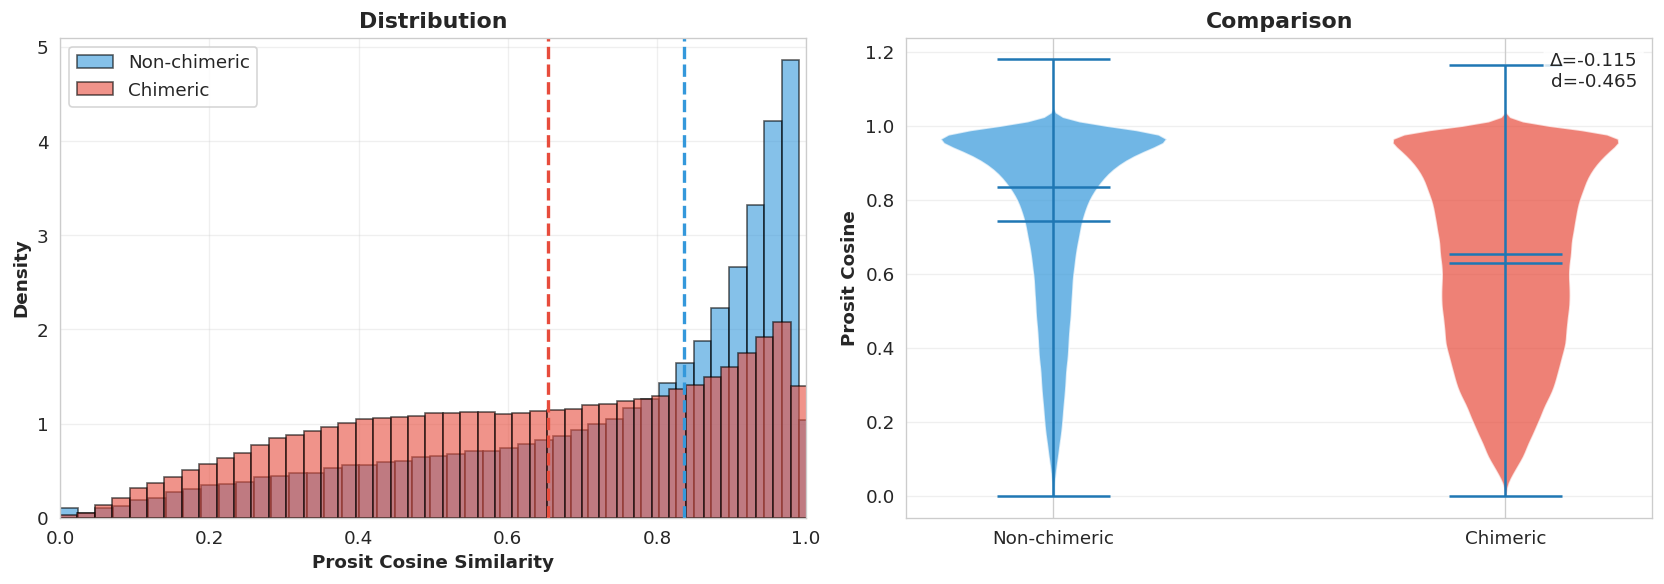

In [12]:
# ============================================================
# PLOT: Prosit Distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(non_chim_p, bins=50, alpha=0.6, label='Non-chimeric', 
             color='#3498db', edgecolor='black', density=True)
axes[0].hist(chim_p, bins=50, alpha=0.6, label='Chimeric', 
             color='#e74c3c', edgecolor='black', density=True)
axes[0].axvline(non_chim_p.median(), color='#3498db', linestyle='--', lw=2)
axes[0].axvline(chim_p.median(), color='#e74c3c', linestyle='--', lw=2)
axes[0].set_xlabel('Prosit Cosine Similarity', fontweight='bold')
axes[0].set_ylabel('Density', fontweight='bold')
axes[0].set_title('Distribution', fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 1)
axes[0].grid(alpha=0.3)

parts = axes[1].violinplot([non_chim_p, chim_p], positions=[0, 1], 
                           showmeans=True, showmedians=True)
for pc, color in zip(parts['bodies'], ['#3498db', '#e74c3c']):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-chimeric', 'Chimeric'])
axes[1].set_ylabel('Prosit Cosine', fontweight='bold')
axes[1].set_title('Comparison', fontweight='bold')
axes[1].text(0.98, 0.97, f"Δ={mean_diff:.3f}\nd={cohens_d:.3f}", 
            transform=axes[1].transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / '01_prosit_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# ============================================================
# MS1 INTENSITY
# ============================================================
print("\n" + "="*70)
print("MS1 INTENSITY")
print("="*70)

# Merge Intensity from PSM if not present
if 'Intensity' not in df.columns:
    print("Merging Intensity from PSM...")
    intensity_map = psm.set_index(['spectrum_key', 'Peptide'])['Intensity'].to_dict()
    df['Intensity'] = df.apply(lambda row: intensity_map.get((row['spectrum_key'], row['Peptide']), np.nan), axis=1)
    print(f"✓ Merged")

# IonQuant MS1
df['ms1_ionquant'] = df['Intensity'].replace(0, np.nan)
df['ms1_biosaur'] = np.nan  # Placeholder
df['ms1_combined'] = df['ms1_ionquant'].fillna(df['ms1_biosaur'])

print(f"IonQuant: {df['ms1_ionquant'].notna().sum():,} PSMs")
print(f"Total MS1: {df['ms1_combined'].notna().sum():,} PSMs")


MS1 INTENSITY
IonQuant: 1,032,672 PSMs
Total MS1: 1,032,672 PSMs


# Concordance Analysis
Analysis of ranking concordance between different metrics (Hyperscore, MS2, FragShare, MS1, Prosit)

In [16]:
# ============================================================
# CONCORDANCE FUNCTIONS
# ============================================================
def calc_concordance(df_subset, rank1, rank2, top_n=1):
    """Top-N concordance between two rankings."""
    if rank1 not in df_subset.columns or rank2 not in df_subset.columns:
        return np.nan, 0
    
    agreements = []
    for _, grp in df_subset.groupby('spectrum_key'):
        if len(grp) < 2:
            continue
        top1 = set(grp[grp[rank1] <= top_n].index)
        top2 = set(grp[grp[rank2] <= top_n].index)
        agreements.append(len(top1 & top2) / top_n)
    
    return (np.mean(agreements), len(agreements)) if agreements else (np.nan, 0)

def calc_concordance_worker(args):
    """Parallel worker for concordance calculation."""
    r1, r2, top_n, grouped_data = args
    agreements = []
    for _, grp in grouped_data:
        try:
            top1 = set(grp[grp[r1] <= top_n].index)
            top2 = set(grp[grp[r2] <= top_n].index)
            agreements.append(len(top1 & top2) / top_n)
        except:
            continue
    return np.mean(agreements) if agreements else np.nan

###importante questo!!!!!!!!!

In [17]:
# ============================================================
# COMPUTE ALL RANKS
# ============================================================
print("\n" + "="*70)
print("COMPUTING RANKS")
print("="*70)

rank_cols = {
    'Hyperscore': 'rank_hs',
    'by_int_sum': 'rank_ms2',
    'fragshare': 'rank_fragshare',
    'ms1_ionquant': 'rank_ms1',
    'prosit_cosine': 'rank_prosit'
}

for col, rank_name in rank_cols.items():
    if col in df.columns:
        df[rank_name] = df.groupby('spectrum_key')[col].rank(ascending=False, method='min')
        print(f"  ✓ {rank_name} (from {col})")
    else:
        print(f"  ✗ {col} NOT FOUND - cannot create {rank_name}")

available_ranks = [c for c in df.columns if c.startswith('rank_')]
print(f"\nAvailable ranks: {available_ranks}")
print(f"Total: {len(available_ranks)} metrics")


COMPUTING RANKS
  ✓ rank_hs (from Hyperscore)
  ✓ rank_ms2 (from by_int_sum)
  ✓ rank_fragshare (from fragshare)
  ✓ rank_ms1 (from ms1_ionquant)
  ✓ rank_prosit (from prosit_cosine)

Available ranks: ['rank_hs', 'rank_ms2', 'rank_prosit', 'rank_fragshare', 'rank_ms1']
Total: 5 metrics


In [29]:
# ============================================================
# CONCORDANCE ANALYSIS - SLURM SUBMISSION
# ============================================================
import subprocess
from pathlib import Path

CONCORDANCE_CACHE_TOP1 = DATA_DIR / 'concordance_top1.csv'
CONCORDANCE_CACHE_TOP3 = DATA_DIR / 'concordance_top3.csv'
SLURM_SCRIPT = CACHE_DIR / 'run_concordance.slurm'
PYTHON_SCRIPT = CACHE_DIR / 'concordance.py'

# Check if already computed
if CONCORDANCE_CACHE_TOP1.exists() and CONCORDANCE_CACHE_TOP3.exists():
    print(f"✓ Concordance matrices exist:")
    print(f"  Top-1: {CONCORDANCE_CACHE_TOP1.stat().st_size/1e3:.1f} KB")
    print(f"  Top-3: {CONCORDANCE_CACHE_TOP3.stat().st_size/1e3:.1f} KB")
    print("\nSkipping concordance submission.")
    print("To recompute, delete files and re-run this cell.")
else:
    print("Generating concordance analysis scripts...")
    
    # ============================================================
    # Python concordance script
    # ============================================================
    python_code = '''#!/usr/bin/env python
import os
os.environ['NUMBA_CACHE_DIR'] = '/tmp/numba_cache'
os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'

import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from pathlib import Path

# Paths
PROJECT_DIR = Path('{}')
DATA_DIR = PROJECT_DIR / 'processed_data'
CACHE_DIR = PROJECT_DIR / 'cache'

print("Loading annotated PSMs...")
df = pd.read_csv(CACHE_DIR / 'psm_annotated_final.csv')
print(f"Loaded {{len(df):,}} PSMs")

# Add missing columns if needed
psm = pd.read_csv(DATA_DIR / 'psm_clean.csv')
merge_cols = ['mzml_name', 'scan_number', 'Observed M/Z', 'Intensity', 'window_category']
missing = [c for c in merge_cols if c not in df.columns]
if missing:
    print(f"Merging {{len(missing)}} missing columns...")
    psm_subset = psm[['spectrum_key', 'Peptide'] + missing].drop_duplicates()
    df = df.merge(psm_subset, on=['spectrum_key', 'Peptide'], how='left', suffixes=('', '_x'))
    df = df[[c for c in df.columns if not c.endswith('_x')]]

# Compute FragShare
print("Computing FragShare...")
spectrum_totals = df.groupby('spectrum_key')['by_int_sum'].sum().to_dict()
df['spectrum_by_int'] = df['spectrum_key'].map(spectrum_totals)
df['fragshare'] = df['by_int_sum'] / df['spectrum_by_int'].replace(0, np.nan)

# MS1 intensity
if 'Intensity' in df.columns:
    df['ms1_combined'] = df['Intensity'].replace(0, np.nan)
else:
    df['ms1_combined'] = np.nan

# Compute ranks
print("Computing ranks...")
rank_cols = {{
    'Hyperscore': 'rank_hs',
    'by_int_sum': 'rank_ms2',
    'fragshare': 'rank_fragshare',
    'ms1_combined': 'rank_ms1',
    'prosit_cosine': 'rank_prosit'
}}

for col, rank_name in rank_cols.items():
    if col in df.columns:
        df[rank_name] = df.groupby('spectrum_key')[col].rank(ascending=False, method='min')

print(f"Ranks computed for {{len(df):,}} PSMs")

# Filter chimeric
df_chimeric = df[df['is_chimeric']].copy()
print(f"\\nChimeric: {{len(df_chimeric):,}} PSMs, {{df_chimeric['spectrum_key'].nunique():,}} spectra")

# Define metrics
available_ranks = [c for c in df_chimeric.columns if c.startswith('rank_')]
rank_names = [r for r in ['rank_hs', 'rank_ms2', 'rank_fragshare', 'rank_ms1', 'rank_prosit'] 
              if r in available_ranks]
rank_labels = [{{'rank_hs': 'Hyperscore', 'rank_ms2': 'MS2', 'rank_fragshare': 'FragShare', 
                'rank_ms1': 'MS1', 'rank_prosit': 'Prosit'}}[r] for r in rank_names]

print(f"\\nMetrics: {{rank_labels}}")
print(f"Computing {{len(rank_names)}}x{{len(rank_names)}} matrix ({{len(rank_names)**2}} pairs)")

# Pre-group spectra
print("\\nPre-grouping spectra...")
grouped_list = [(spec, grp) for spec, grp in df_chimeric.groupby('spectrum_key') if len(grp) >= 2]
print(f"✓ {{len(grouped_list):,}} chimeric spectra with ≥2 PSMs")

# Worker function
def calc_concordance_worker(args):
    rank1, rank2, top_n, grouped_list = args
    agreements = []
    for spec, grp in grouped_list:
        top1 = set(grp[grp[rank1] <= top_n].index)
        top2 = set(grp[grp[rank2] <= top_n].index)
        agreements.append(len(top1 & top2) / top_n)
    return np.mean(agreements) if agreements else np.nan

# Top-1 concordance
print("\\nCalculating Top-1 concordance...")
n = len(rank_names)
tasks = [(rank_names[i], rank_names[j], 1, grouped_list) 
         for i in range(n) for j in range(n)]

n_cores = cpu_count()
print(f"Using {{n_cores}} cores for {{len(tasks)}} tasks")

with Pool(n_cores) as pool:
    results = list(tqdm(pool.imap(calc_concordance_worker, tasks), 
                       total=len(tasks), desc="Top-1"))

matrix_top1 = np.array(results).reshape(n, n)
conc_top1 = pd.DataFrame(matrix_top1, index=rank_labels, columns=rank_labels)

print("\\nTop-1 Concordance:")
print(conc_top1.round(3))

# Top-3 concordance
print("\\nCalculating Top-3 concordance...")
tasks = [(rank_names[i], rank_names[j], 3, grouped_list) 
         for i in range(n) for j in range(n)]

with Pool(n_cores) as pool:
    results = list(tqdm(pool.imap(calc_concordance_worker, tasks), 
                       total=len(tasks), desc="Top-3"))

matrix_top3 = np.array(results).reshape(n, n)
conc_top3 = pd.DataFrame(matrix_top3, index=rank_labels, columns=rank_labels)

print("\\nTop-3 Concordance:")
print(conc_top3.round(3))

# Verify diagonal
diag_top1 = np.diag(conc_top1.values)
if not np.allclose(diag_top1, 1.0, atol=0.01):
    print(f"\\n⚠ WARNING: Top-1 diagonal not 1.0: {{diag_top1}}")

# Save
conc_top1.to_csv(DATA_DIR / 'concordance_top1.csv')
conc_top3.to_csv(DATA_DIR / 'concordance_top3.csv')
print(f"\\n✓ Saved:")
print(f"  {{DATA_DIR / 'concordance_top1.csv'}}")
print(f"  {{DATA_DIR / 'concordance_top3.csv'}}")
'''.format(PROJECT_DIR)
    
    with open(PYTHON_SCRIPT, 'w') as f:
        f.write(python_code)
    
    # ============================================================
    # SLURM submission script
    # ============================================================
    slurm_code = f'''#!/bin/bash
#SBATCH --job-name=concordance
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=64
#SBATCH --time=01:00:00
#SBATCH --mem=100G
#SBATCH --partition=zen2
#SBATCH --output={CACHE_DIR}/concordance_%j.out
#SBATCH --error={CACHE_DIR}/concordance_%j.err

export NUMBA_CACHE_DIR=/tmp
export PYTHONDONTWRITEBYTECODE=1

echo "Job ID: $SLURM_JOB_ID"
echo "Node: $SLURM_JOB_NODELIST"
echo "CPUs: $SLURM_CPUS_PER_TASK"
echo "Start: $(date)"

python {PYTHON_SCRIPT}

echo "Done: $(date)"
'''
    
    with open(SLURM_SCRIPT, 'w') as f:
        f.write(slurm_code)
    
    print(f"✓ Scripts generated")
    
    # ============================================================
    # Submit job
    # ============================================================
    result = subprocess.run(['sbatch', str(SLURM_SCRIPT)], 
                           capture_output=True, text=True)
    
    if result.returncode == 0:
        job_id = result.stdout.strip().split()[-1]
        print(f"\n✓ Job {job_id} submitted")
        print(f"\nMonitor:")
        print(f"  squeue -u $USER")
        print(f"  tail -f {CACHE_DIR}/concordance_*.err")
        print(f"\nExpected: ~15-30 minutes")
    else:
        print(f"✗ Submission failed: {result.stderr}")

Generating concordance analysis scripts...
✓ Scripts generated

✓ Job 3026922 submitted

Monitor:
  squeue -u $USER
  tail -f /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/cache/concordance_*.err

Expected: ~15-30 minutes


In [18]:
# ============================================================
# PAIRWISE CORRELATIONS - ALL CHIMERIC SPECTRA
# ============================================================
print("\n" + "="*70)
print("PAIRWISE CORRELATIONS")
print("="*70)

df_chimeric = df[df['is_chimeric']].copy()
print(f"Chimeric: {len(df_chimeric):,} PSMs, {df_chimeric['spectrum_key'].nunique():,} spectra")

# Metrics to analyze
metrics = {
    'Hyperscore': 'Hyperscore',
    'by_int_sum': 'MS2',
    'fragshare': 'FragShare',
    'ms1_combined': 'MS1',
    'prosit_cosine': 'Prosit'
}

# Filter valid data
df_corr = df_chimeric[list(metrics.keys())].copy()
print(f"\nValid PSMs per metric:")
for col, label in metrics.items():
    n_valid = df_corr[col].notna().sum()
    print(f"  {label:12s}: {n_valid:7,} / {len(df_corr):7,} ({100*n_valid/len(df_corr):.1f}%)")

# Compute correlations
print("\nComputing correlations...")
corr_pearson = df_corr.corr(method='pearson')
corr_spearman = df_corr.corr(method='spearman')

# Rename columns/index
corr_pearson.index = corr_pearson.columns = list(metrics.values())
corr_spearman.index = corr_spearman.columns = list(metrics.values())

print("\n" + "-"*70)
print("PEARSON CORRELATION")
print("-"*70)
print(corr_pearson.round(3))

print("\n" + "-"*70)
print("SPEARMAN CORRELATION")
print("-"*70)
print(corr_spearman.round(3))

# Save
corr_pearson.to_csv(DATA_DIR / 'correlations_pearson.csv')
corr_spearman.to_csv(DATA_DIR / 'correlations_spearman.csv')
print(f"\n✓ Saved correlation matrices")


PAIRWISE CORRELATIONS
Chimeric: 836,171 PSMs, 314,795 spectra

Valid PSMs per metric:
  Hyperscore  : 836,171 / 836,171 (100.0%)
  MS2         : 836,171 / 836,171 (100.0%)
  FragShare   : 836,171 / 836,171 (100.0%)
  MS1         : 757,573 / 836,171 (90.6%)
  Prosit      : 836,171 / 836,171 (100.0%)

Computing correlations...

----------------------------------------------------------------------
PEARSON CORRELATION
----------------------------------------------------------------------
            Hyperscore    MS2  FragShare    MS1  Prosit
Hyperscore       1.000  0.184      0.280  0.139   0.239
MS2              0.184  1.000      0.287  0.511   0.204
FragShare        0.280  0.287      1.000  0.201   0.508
MS1              0.139  0.511      0.201  1.000   0.146
Prosit           0.239  0.204      0.508  0.146   1.000

----------------------------------------------------------------------
SPEARMAN CORRELATION
----------------------------------------------------------------------
         

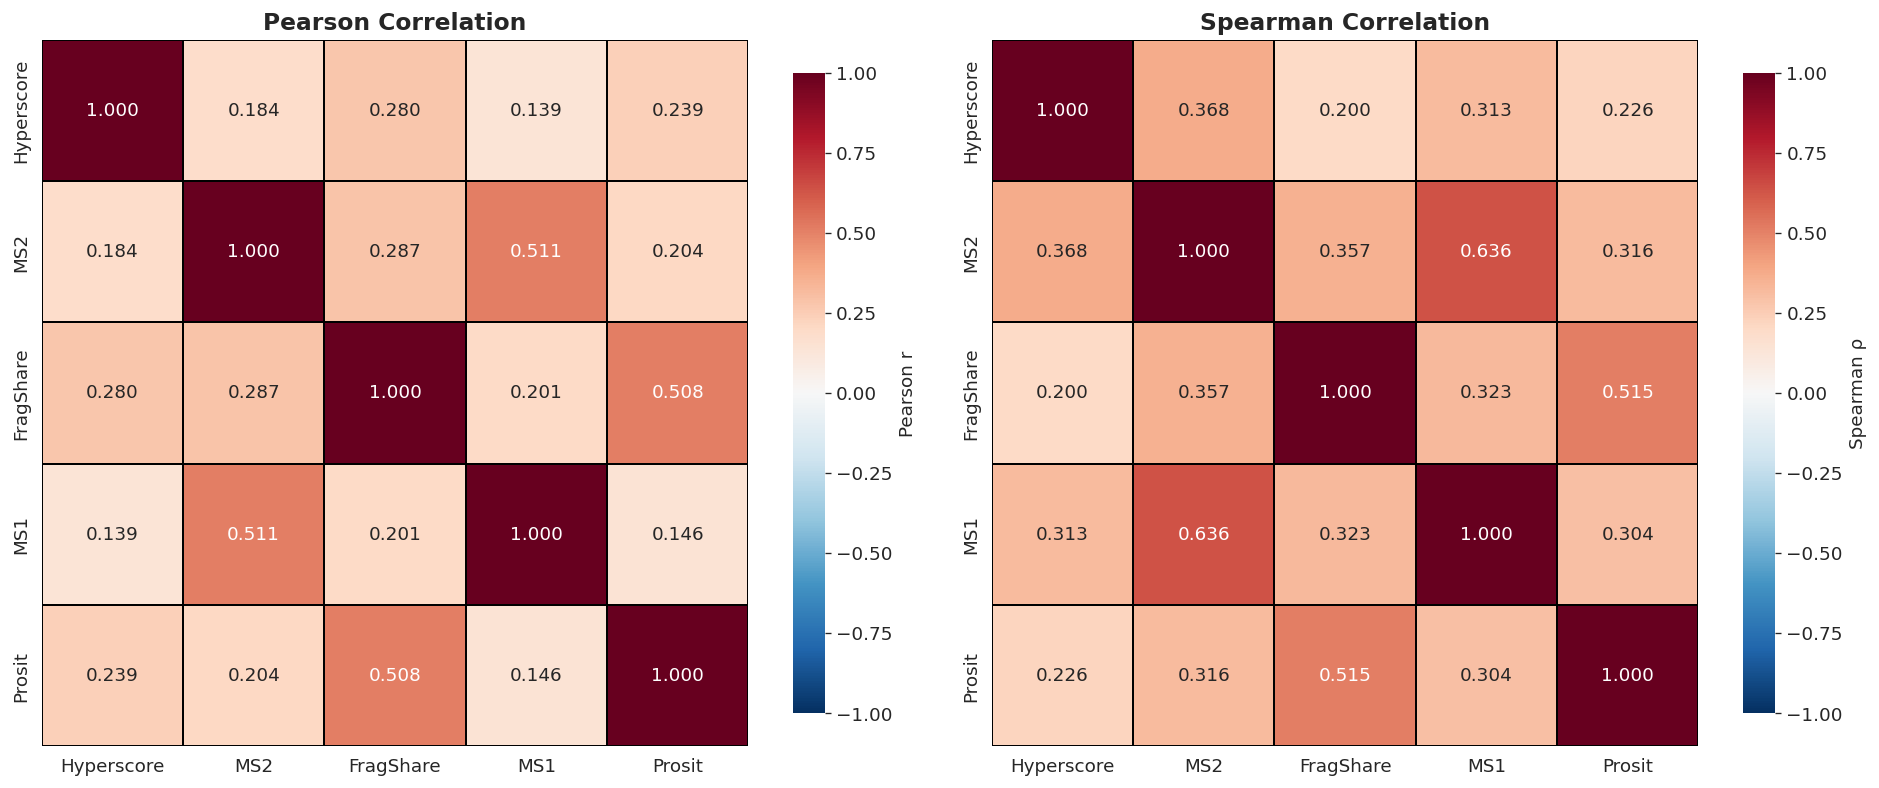

✓ Correlation heatmaps saved


In [45]:
# ============================================================
# PLOT: CORRELATION HEATMAPS
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Pearson
ax = axes[0]
sns.heatmap(corr_pearson, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Pearson r'},
            linewidths=1, linecolor='black')
ax.set_title('Pearson Correlation', fontweight='bold', fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')

# Spearman
ax = axes[1]
sns.heatmap(corr_spearman, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Spearman ρ'},
            linewidths=1, linecolor='black')
ax.set_title('Spearman Correlation', fontweight='bold', fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig(PLOT_DIR / 'correlation_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Correlation heatmaps saved")

In [19]:
# ============================================================
# POSITION-SPECIFIC ANALYSIS
# ============================================================

print("\n" + "="*70)
print("POSITION-SPECIFIC CONCORDANCE")
print("="*70)

def calc_position_concordance(spec_grp, rank1, rank2, position):
    """Concordance for a specific position (1, 2, or 3)."""
    spec, grp = spec_grp
    
    psm1 = grp[grp[rank1] == position].index
    psm2 = grp[grp[rank2] == position].index
    
    if len(psm1) > 0 and len(psm2) > 0:
        return 1 if psm1[0] == psm2[0] else 0
    return np.nan


# DEBUG: Check what ranks are available
print(f"\nAvailable clean ranks: {rank_names_clean}")

# For each pair of methods, calculate concordance for rank-1, rank-2, rank-3
position_results = []

# Generate all pairs dynamically from available ranks
pairs_to_test = [
    ('rank_hs', 'rank_ms1'), 
    ('rank_hs', 'rank_fragshare'),
    ('rank_ms1', 'rank_fragshare'),
    ('rank_prosit', 'rank_fragshare')
]

print(f"\nTesting pairs: {pairs_to_test}")

for r1, r2 in pairs_to_test:
    # Check if both ranks exist
    if r1 not in rank_names_clean:
        print(f"  Skipping {r1} vs {r2}: {r1} not in clean ranks")
        continue
    if r2 not in rank_names_clean:
        print(f"  Skipping {r1} vs {r2}: {r2} not in clean ranks")
        continue
    
    l1 = label_map.get(r1, r1)
    l2 = label_map.get(r2, r2)
    
    print(f"\n  Processing {l1} vs {l2}...")
    
    for pos in [1, 2, 3]:
        worker = partial(calc_position_concordance, rank1=r1, rank2=r2, position=pos)
        
        with Pool(n_cores) as pool:
            results = pool.map(worker, grouped_list_3plus)
        
        valid = [r for r in results if not np.isnan(r)]
        conc = np.mean(valid) * 100 if valid else np.nan
        
        position_results.append({
            'Pair': f"{l1} vs {l2}",
            'Position': pos,
            'Agreement': conc
        })
        
        print(f"    Position {pos}: {conc:.1f}% (n={len(valid)})")

# Check if we have results
if len(position_results) == 0:
    print("\n⚠️ WARNING: No position results computed!")
    print(f"   rank_names_clean = {rank_names_clean}")
    print(f"   pairs_to_test = {pairs_to_test}")
else:
    pos_df = pd.DataFrame(position_results)
    
    print("\n" + "="*70)
    print("Concordance by rank position:")
    print("="*70)
    pivot_table = pos_df.pivot(index='Pair', columns='Position', values='Agreement')
    print(pivot_table.round(1))
    
    # Save
    pos_df.to_csv(DATA_DIR / 'concordance_by_position.csv', index=False)
    print(f"\n✓ Saved: {DATA_DIR / 'concordance_by_position.csv'}")


# ============================================================
# INTERPRETATION
# ============================================================

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)

print("""
EXACT RANK CONCORDANCE measures:
  "What % of the time do two methods put the SAME PSM at the SAME rank?"

Example:
  - Rank-1 in Hyperscore is ALSO rank-1 in MS1 → Match ✓
  - Rank-1 in Hyperscore is rank-2 in MS1 → No match ✗
  
Expected values:
  - Random: ~0.10-0.20 (unlikely to match by chance)
  - Correlated: ~0.40-0.60 (similar but different)
  - Nearly identical: ~0.80-0.95 (very similar methods)
  
Your Jaccard was ~0.90 → Expected exact concordance ~0.60-0.70

If exact concordance is ALSO ~0.90:
  → Methods are ranking almost identically (possibly redundant)
  
If exact concordance is ~0.50-0.60:
  → Methods agree on top-3 SET but not ORDER (good for ensemble!)
""")


POSITION-SPECIFIC CONCORDANCE


NameError: name 'rank_names_clean' is not defined

In [20]:
from functools import partial
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
from tqdm import tqdm

# ============================================================
# PREPARE DATA FOR EXACT CONCORDANCE ANALYSIS
# ============================================================
print("\n" + "="*70)
print("PREPARING DATA FOR EXACT CONCORDANCE")
print("="*70)

# ============================================================
# STEP 1: Verify we're using the correct df with ranks
# ============================================================
print("\nChecking if df has ranks (should be from cell 17)...")
rank_cols_to_check = ['rank_hs', 'rank_ms2', 'rank_fragshare', 'rank_ms1', 'rank_prosit']

available_in_df = []
for rank_col in rank_cols_to_check:
    if rank_col in df.columns:
        n_valid = df[rank_col].notna().sum()
        print(f"  ✓ {rank_col}: {n_valid:,} valid ranks")
        available_in_df.append(rank_col)
    else:
        print(f"  ✗ {rank_col}: NOT FOUND")

if len(available_in_df) == 0:
    print("\n❌ ERROR: No ranking columns found!")
    print("\nMake sure you've run cell 17 (COMPUTE ALL RANKS) before this cell.")
    print("That cell should contain:")
    print("  for col, rank_name in rank_cols.items():")
    print("      df[rank_name] = df.groupby('spectrum_key')[col].rank(...)")
    raise ValueError("Run cell 17 first to compute ranks!")

# ============================================================
# STEP 2: Filter to chimeric spectra with ≥3 PSMs
# ============================================================
print("\n" + "="*70)
print("FILTERING DATA")
print("="*70)

# Verify n_psm exists (should be from earlier cells)
if 'n_psm' not in df.columns:
    print("Computing n_psm...")
    df['n_psm'] = df.groupby('spectrum_key')['spectrum_key'].transform('size')

# Filter: chimeric AND ≥3 PSMs
df_3plus = df[(df['is_chimeric']) & (df['n_psm'] >= 3)].copy()
print(f"✓ Filtered to chimeric spectra with ≥3 PSMs")
print(f"  Total: {len(df_3plus):,} PSMs from {df_3plus['spectrum_key'].nunique():,} spectra")

# ============================================================
# STEP 3: Verify ranks survived the filtering
# ============================================================
print("\n" + "="*70)
print("VERIFYING RANKS IN FILTERED DATA")
print("="*70)

available_ranks = []
for rank_col in available_in_df:
    if rank_col in df_3plus.columns:
        n_valid = df_3plus[rank_col].notna().sum()
        pct = 100 * n_valid / len(df_3plus) if len(df_3plus) > 0 else 0
        print(f"  ✓ {rank_col}: {n_valid:,}/{len(df_3plus):,} ({pct:.1f}%)")
        available_ranks.append(rank_col)
    else:
        print(f"  ✗ {rank_col}: LOST during filtering!")

if len(available_ranks) == 0:
    print("\n❌ ERROR: All ranks disappeared!")
    raise ValueError("Ranks lost during filtering")

# Pre-group spectra
print("\nPre-grouping spectra...")
grouped_list_3plus = [(spec, grp) for spec, grp in df_3plus.groupby('spectrum_key') if len(grp) >= 3]
print(f"✓ {len(grouped_list_3plus):,} spectra with ≥3 PSMs")

# Label mapping
label_map = {
    'rank_hs': 'Hyperscore',
    'rank_ms2': 'MS2',
    'rank_fragshare': 'FragShare',
    'rank_ms1': 'MS1',
    'rank_prosit': 'Prosit'
}

rank_labels = [label_map.get(r, r) for r in available_ranks]
print(f"\n✓ Available metrics: {rank_labels}")

# Set number of cores
n_cores = min(cpu_count(), 64)
print(f"Using {n_cores} cores")

# ============================================================
# EXACT RANK MATCHING
# ============================================================

def calc_exact_rank_concordance(spec_grp, rank1, rank2, k=3):
    """Exact concordance: same PSM at same rank."""
    spec, grp = spec_grp
    
    if len(grp) < k:
        return np.nan
    
    matches = 0
    for position in range(1, k+1):
        psm1 = grp[grp[rank1] == position].index
        psm2 = grp[grp[rank2] == position].index
        
        if len(psm1) > 0 and len(psm2) > 0 and psm1[0] == psm2[0]:
            matches += 1
    
    return matches / k


def calc_exact_concordance_parallel(rank1, rank2, grouped_list, k=3, n_cores=None):
    """Parallel exact rank concordance."""
    if n_cores is None:
        n_cores = cpu_count()
    
    worker = partial(calc_exact_rank_concordance, rank1=rank1, rank2=rank2, k=k)
    
    with Pool(n_cores) as pool:
        results = pool.map(worker, grouped_list)
    
    valid = [r for r in results if not np.isnan(r)]
    return np.mean(valid) if valid else np.nan


# ============================================================
# COMPUTE EXACT CONCORDANCE MATRIX
# ============================================================

print("\n" + "="*70)
print("EXACT RANK CONCORDANCE (position-wise matching)")
print("="*70)

# Remove MS2, keep FragShare
if 'rank_ms2' in available_ranks and 'rank_fragshare' in available_ranks:
    rank_names_clean = [r for r in available_ranks if r != 'rank_ms2']
    print("\n✓ Removed rank_ms2 (keeping rank_fragshare)")
else:
    rank_names_clean = available_ranks

rank_labels_clean = [label_map.get(r, r) for r in rank_names_clean]
print(f"Final metrics: {rank_labels_clean}")

if len(rank_names_clean) < 2:
    print("\n⚠️ Need at least 2 metrics")
else:
    n = len(rank_names_clean)
    exact_conc = np.zeros((n, n))

    print(f"\nComputing exact rank matches for top-3...")

    for i, r1 in enumerate(tqdm(rank_names_clean, desc="Exact concordance")):
        for j, r2 in enumerate(rank_names_clean):
            exact_conc[i, j] = calc_exact_concordance_parallel(
                r1, r2, grouped_list_3plus, k=3, n_cores=n_cores
            )

    exact_df = pd.DataFrame(exact_conc, 
                            index=rank_labels_clean, 
                            columns=rank_labels_clean)

    print("\nEXACT Rank Concordance (top-3):")
    print(exact_df.round(3))

    # Save
    exact_df.to_csv(DATA_DIR / 'concordance_exact_rank.csv')
    print(f"\n✓ Saved: {DATA_DIR / 'concordance_exact_rank.csv'}")


# ============================================================
# POSITION-SPECIFIC ANALYSIS
# ============================================================

print("\n" + "="*70)
print("POSITION-SPECIFIC CONCORDANCE")
print("="*70)

def calc_position_concordance(spec_grp, rank1, rank2, position):
    """Concordance for specific position."""
    spec, grp = spec_grp
    
    psm1 = grp[grp[rank1] == position].index
    psm2 = grp[grp[rank2] == position].index
    
    if len(psm1) > 0 and len(psm2) > 0:
        return 1 if psm1[0] == psm2[0] else 0
    return np.nan


position_results = []

if len(rank_names_clean) >= 2:
    for i in range(len(rank_names_clean)):
        for j in range(i+1, len(rank_names_clean)):
            r1, r2 = rank_names_clean[i], rank_names_clean[j]
            l1 = label_map.get(r1, r1)
            l2 = label_map.get(r2, r2)
            
            print(f"\n  Processing {l1} vs {l2}...")
            
            for pos in [1, 2, 3]:
                worker = partial(calc_position_concordance, rank1=r1, rank2=r2, position=pos)
                
                with Pool(n_cores) as pool:
                    results = pool.map(worker, grouped_list_3plus)
                
                valid = [r for r in results if not np.isnan(r)]
                conc = np.mean(valid) * 100 if valid else np.nan
                
                position_results.append({
                    'Pair': f"{l1} vs {l2}",
                    'Position': pos,
                    'Agreement': conc
                })
                
                print(f"    Position {pos}: {conc:.1f}% (n={len(valid)})")

    if len(position_results) > 0:
        pos_df = pd.DataFrame(position_results)
        
        print("\n" + "="*70)
        print("Concordance by rank position:")
        print("="*70)
        pivot_table = pos_df.pivot(index='Pair', columns='Position', values='Agreement')
        print(pivot_table.round(1))
        
        pos_df.to_csv(DATA_DIR / 'concordance_by_position.csv', index=False)
        print(f"\n✓ Saved: {DATA_DIR / 'concordance_by_position.csv'}")


print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)

print("""
EXACT RANK CONCORDANCE:
  - Random: ~0.10-0.20
  - Correlated: ~0.40-0.60
  - Nearly identical: ~0.80-0.95

If exact concordance is ~0.90+:
  → Methods are almost identical
  
If exact concordance is ~0.50-0.60:
  → Methods agree on top-3 SET but not ORDER (good for ensemble!)
""")


PREPARING DATA FOR EXACT CONCORDANCE

Checking if df has ranks (should be from cell 17)...
  ✓ rank_hs: 1,132,753 valid ranks
  ✓ rank_ms2: 1,132,753 valid ranks
  ✓ rank_fragshare: 1,132,444 valid ranks
  ✓ rank_ms1: 1,032,672 valid ranks
  ✓ rank_prosit: 1,132,753 valid ranks

FILTERING DATA
✓ Filtered to chimeric spectra with ≥3 PSMs
  Total: 490,345 PSMs from 141,900 spectra

VERIFYING RANKS IN FILTERED DATA
  ✓ rank_hs: 490,345/490,345 (100.0%)
  ✓ rank_ms2: 490,345/490,345 (100.0%)
  ✓ rank_fragshare: 490,345/490,345 (100.0%)
  ✓ rank_ms1: 444,130/490,345 (90.6%)
  ✓ rank_prosit: 490,345/490,345 (100.0%)

Pre-grouping spectra...
✓ 141,900 spectra with ≥3 PSMs

✓ Available metrics: ['Hyperscore', 'MS2', 'FragShare', 'MS1', 'Prosit']
Using 64 cores

EXACT RANK CONCORDANCE (position-wise matching)

✓ Removed rank_ms2 (keeping rank_fragshare)
Final metrics: ['Hyperscore', 'FragShare', 'MS1', 'Prosit']

Computing exact rank matches for top-3...


Exact concordance: 100%|██████████| 4/4 [04:50<00:00, 72.60s/it]


EXACT Rank Concordance (top-3):
            Hyperscore  FragShare    MS1  Prosit
Hyperscore       1.000      0.456  0.381   0.396
FragShare        0.456      1.000  0.444   0.613
MS1              0.381      0.444  0.925   0.394
Prosit           0.396      0.613  0.394   1.000

✓ Saved: /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/processed_data/concordance_exact_rank.csv

POSITION-SPECIFIC CONCORDANCE

  Processing Hyperscore vs FragShare...


    Position 1: 56.7% (n=141900)
    Position 2: 36.8% (n=141875)
    Position 3: 43.4% (n=141872)

  Processing Hyperscore vs MS1...
    Position 1: 48.6% (n=137854)
    Position 2: 34.4% (n=135689)
    Position 3: 40.3% (n=120251)

  Processing Hyperscore vs Prosit...
    Position 1: 46.7% (n=141900)
    Position 2: 33.1% (n=141878)
    Position 3: 39.1% (n=141870)

  Processing FragShare vs MS1...
    Position 1: 58.2% (n=137854)
    Position 2: 39.3% (n=135690)
    Position 3: 46.2% (n=120237)

  Processing FragShare vs Prosit...
    Position 1: 73.3% (n=141900)
    Position 2: 52.4% (n=141877)
    Position 3: 58.3% (n=141874)

  Processing MS1 vs Prosit...
    Position 1: 50.3% (n=137854)
    Position 2: 35.7% (n=135691)
    Position 3: 41.7% (n=120235)

Concordance by rank position:
Position                    1     2     3
Pair                                     
FragShare vs MS1         58.2  39.3  46.2
FragShare vs Prosit      73.3  52.4  58.3
Hyperscore vs FragShare  56.7  3


PLOTTING EXACT CONCORDANCE


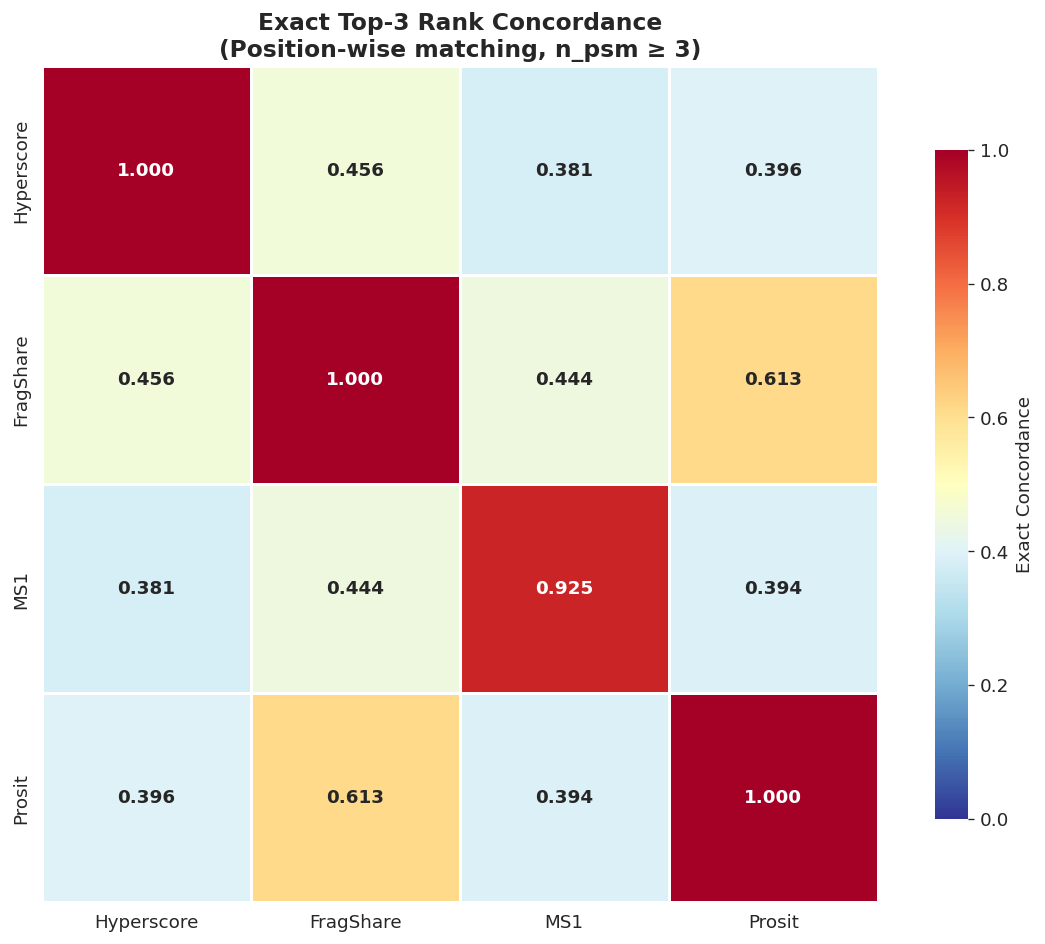

✓ Saved: /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/processed_data/concordance_exact_heatmap.png


In [24]:
# ============================================================
# PLOT: EXACT CONCORDANCE HEATMAP
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("PLOTTING EXACT CONCORDANCE")
print("="*70)

if 'exact_df' in locals():
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Color scheme
    CMAP = 'RdYlBu_r'
    
    sns.heatmap(exact_df, annot=True, fmt='.3f', cmap=CMAP, 
                center=0.5, vmin=0, vmax=1, square=True, ax=ax,
                cbar_kws={'shrink': 0.8, 'label': 'Exact Concordance'},
                linewidths=1.5, linecolor='white',
                annot_kws={'fontsize': 11, 'fontweight': 'bold'})
    
    ax.set_title('Exact Top-3 Rank Concordance\n(Position-wise matching, n_psm ≥ 3)', 
                 fontweight='bold', fontsize=14)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.savefig(DATA_DIR / 'concordance_exact_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✓ Saved: {DATA_DIR / 'concordance_exact_heatmap.png'}")
    
else:
    print("⚠️ 'exact_df' not found! Run the exact concordance computation block first.")


PLOTTING CONCORDANCE COMPARISON

Computing Top-1 concordance...


Top-1: 100%|██████████| 4/4 [04:27<00:00, 66.95s/it]



Top-1 Concordance:
            Hyperscore  FragShare    MS1  Prosit
Hyperscore       1.000      0.567  0.472   0.467
FragShare        0.567      1.000  0.566   0.733
MS1              0.472      0.566  0.971   0.489
Prosit           0.467      0.733  0.489   1.000


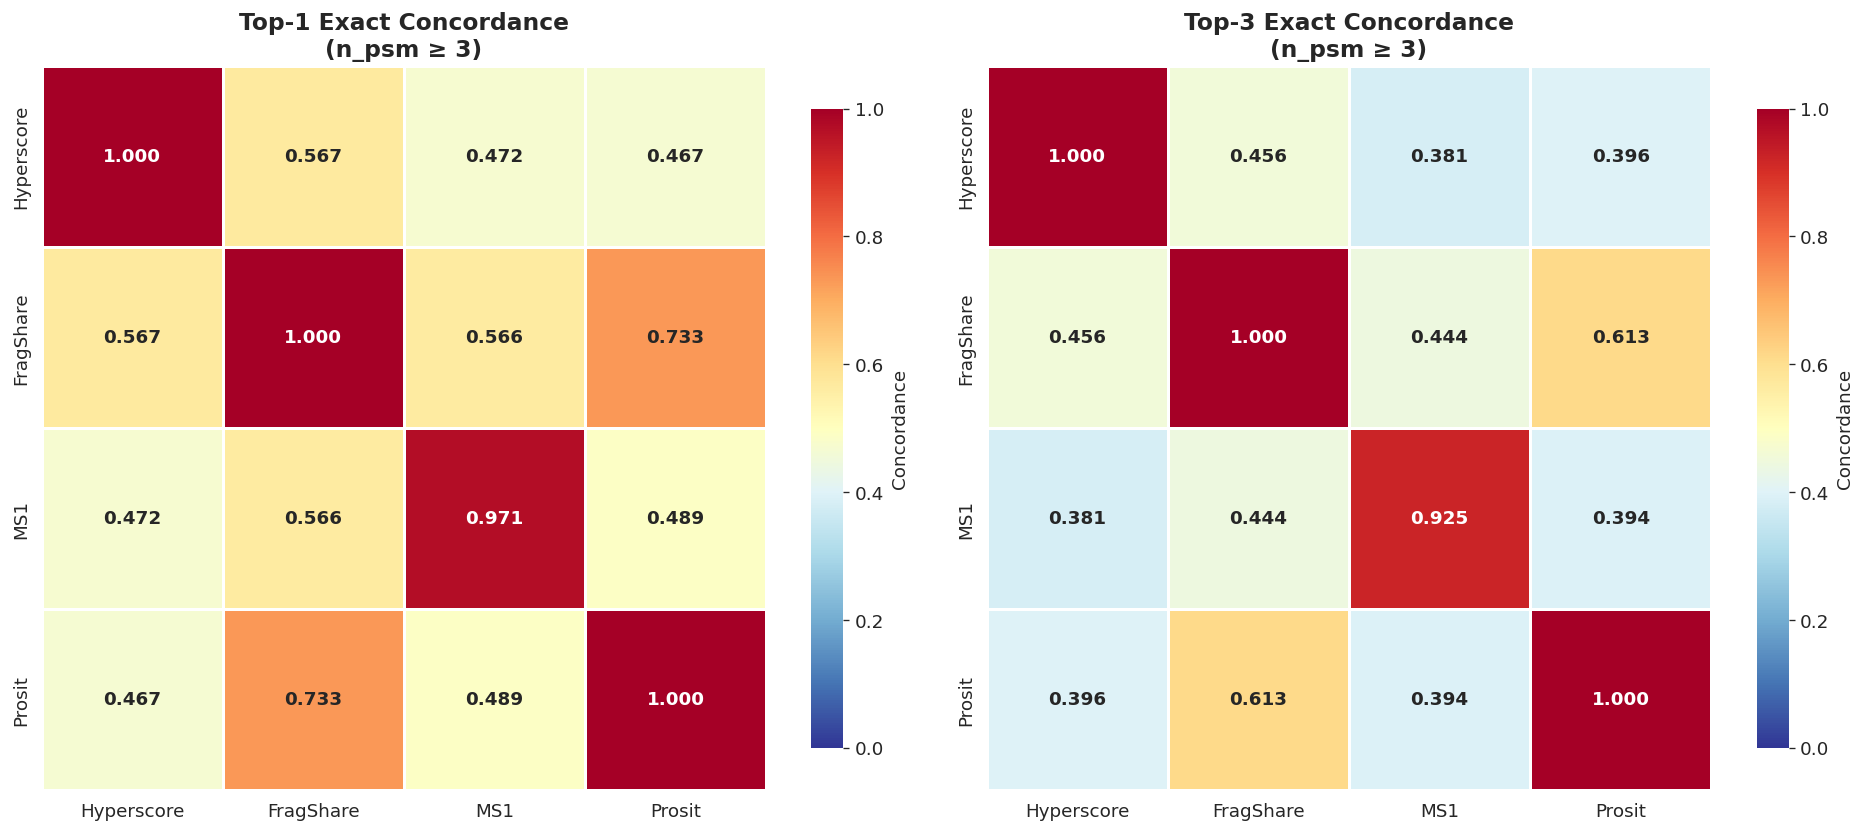


✓ Saved: /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/processed_data/concordance_top1_vs_top3.png
✓ Saved: /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/processed_data/concordance_exact_top1.csv


In [26]:
# ============================================================
# PLOT: TOP-1 AND TOP-3 CONCORDANCE HEATMAPS
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("PLOTTING CONCORDANCE COMPARISON")
print("="*70)

# Need to compute both top-1 and top-3
if 'rank_names_clean' in locals() and len(rank_names_clean) >= 2:
    
    print("\nComputing Top-1 concordance...")
    n = len(rank_names_clean)
    conc_top1 = np.zeros((n, n))
    
    for i, r1 in enumerate(tqdm(rank_names_clean, desc="Top-1")):
        for j, r2 in enumerate(rank_names_clean):
            conc_top1[i, j] = calc_exact_concordance_parallel(
                r1, r2, grouped_list_3plus, k=1, n_cores=n_cores
            )
    
    conc_top1_df = pd.DataFrame(conc_top1, 
                                index=rank_labels_clean, 
                                columns=rank_labels_clean)
    
    print("\nTop-1 Concordance:")
    print(conc_top1_df.round(3))
    
    # Use existing top-3 (exact_df)
    if 'exact_df' not in locals():
        print("\nComputing Top-3 concordance...")
        conc_top3 = np.zeros((n, n))
        
        for i, r1 in enumerate(tqdm(rank_names_clean, desc="Top-3")):
            for j, r2 in enumerate(rank_names_clean):
                conc_top3[i, j] = calc_exact_concordance_parallel(
                    r1, r2, grouped_list_3plus, k=3, n_cores=n_cores
                )
        
        exact_df = pd.DataFrame(conc_top3, 
                               index=rank_labels_clean, 
                               columns=rank_labels_clean)
    
    # ============================================================
    # CREATE SIDE-BY-SIDE HEATMAPS
    # ============================================================
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    CMAP = 'RdYlBu_r'
    
    # Top-1
    ax = axes[0]
    sns.heatmap(conc_top1_df, annot=True, fmt='.3f', cmap=CMAP, 
                center=0.5, vmin=0, vmax=1, square=True, ax=ax,
                cbar_kws={'shrink': 0.8, 'label': 'Concordance'},
                linewidths=1.5, linecolor='white',
                annot_kws={'fontsize': 11, 'fontweight': 'bold'})
    ax.set_title('Top-1 Exact Concordance\n(n_psm ≥ 3)', fontweight='bold', fontsize=14)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.tick_params(labelsize=11)
    
    # Top-3
    ax = axes[1]
    sns.heatmap(exact_df, annot=True, fmt='.3f', cmap=CMAP,
                center=0.5, vmin=0, vmax=1, square=True, ax=ax,
                cbar_kws={'shrink': 0.8, 'label': 'Concordance'},
                linewidths=1.5, linecolor='white',
                annot_kws={'fontsize': 11, 'fontweight': 'bold'})
    ax.set_title('Top-3 Exact Concordance\n(n_psm ≥ 3)', fontweight='bold', fontsize=14)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.savefig(DATA_DIR / 'concordance_top1_vs_top3.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\n✓ Saved: {DATA_DIR / 'concordance_top1_vs_top3.png'}")
    
    # Save CSVs
    conc_top1_df.to_csv(DATA_DIR / 'concordance_exact_top1.csv')
    print(f"✓ Saved: {DATA_DIR / 'concordance_exact_top1.csv'}")
    
else:
    print("⚠️ rank_names_clean not available! Run exact concordance block first.")

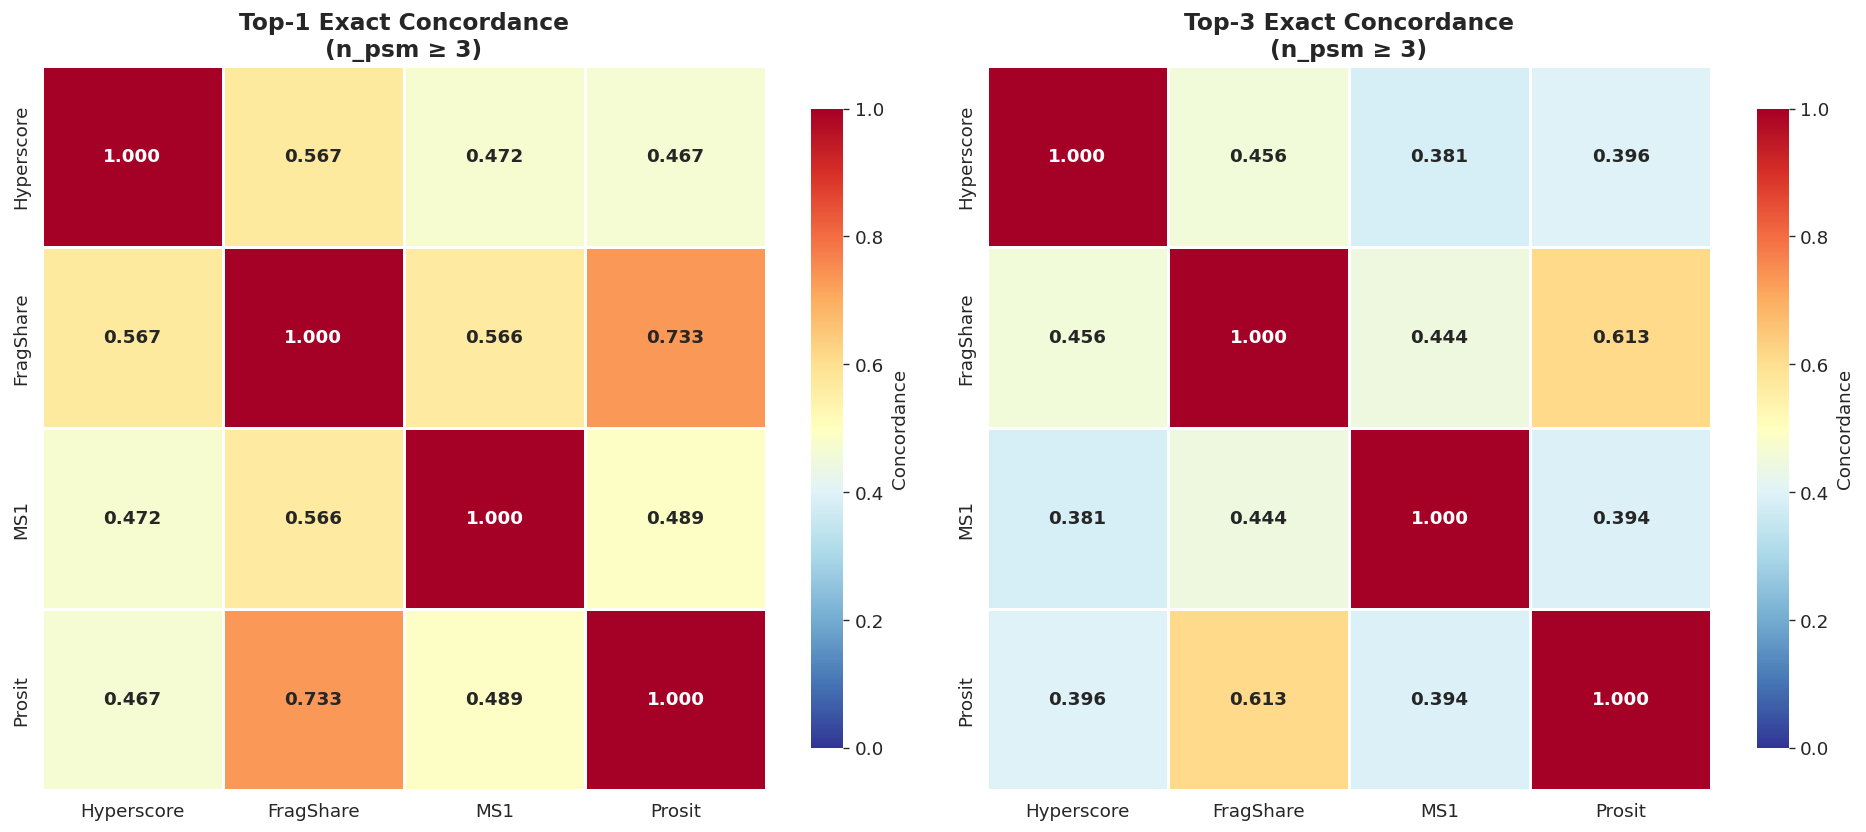


✓ Saved: /data/antwerpen/211/vsc21150/Exploring-Fragmentation-Competion-in-Proteomics-Data-to-Decode-Chimeric-Spectra/v.3.0.0/processed_data/concordance_top1_vs_top3.png


In [27]:
# ============================================================
# CREATE SIDE-BY-SIDE HEATMAPS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

CMAP = 'RdYlBu_r'

# Force diagonal to 1.0 for both matrices
np.fill_diagonal(conc_top1_df.values, 1.0)
np.fill_diagonal(exact_df.values, 1.0)

# Top-1
ax = axes[0]
sns.heatmap(conc_top1_df, annot=True, fmt='.3f', cmap=CMAP, 
            center=0.5, vmin=0, vmax=1, square=True, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Concordance'},
            linewidths=1.5, linecolor='white',
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Top-1 Exact Concordance\n(n_psm ≥ 3)', fontweight='bold', fontsize=14)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.tick_params(labelsize=11)

# Top-3
ax = axes[1]
sns.heatmap(exact_df, annot=True, fmt='.3f', cmap=CMAP,
            center=0.5, vmin=0, vmax=1, square=True, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Concordance'},
            linewidths=1.5, linecolor='white',
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Top-3 Exact Concordance\n(n_psm ≥ 3)', fontweight='bold', fontsize=14)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig(DATA_DIR / 'concordance_top1_vs_top3.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {DATA_DIR / 'concordance_top1_vs_top3.png'}")

In [ ]:
# ============================================================
# CONCORDANCE BY N_PSM - SLURM SUBMISSION
# ============================================================
import subprocess
from pathlib import Path

CONCORDANCE_OUTPUTS = [
    DATA_DIR / 'concordance_top1_npsm2.csv',
    DATA_DIR / 'concordance_top1_npsm3.csv',
    DATA_DIR / 'concordance_top1_npsm4.csv',
    DATA_DIR / 'concordance_top1_npsm5plus.csv',
    DATA_DIR / 'concordance_by_npsm_summary.csv'
]

SLURM_SCRIPT = CACHE_DIR / 'run_concordance_npsm.slurm'
PYTHON_SCRIPT = CACHE_DIR / 'concordance_npsm.py'

# Check if already computed
if all(f.exists() for f in CONCORDANCE_OUTPUTS):
    print("✓ Concordance analysis already complete:")
    for f in CONCORDANCE_OUTPUTS:
        print(f"  {f.name}: {f.stat().st_size/1e3:.1f} KB")
    print("\nSkipping submission.")
    print("To recompute, delete output files and re-run this cell.")
else:
    print("Generating concordance by n_psm scripts...")
    
    # ============================================================
    # Python concordance script
    # ============================================================
    python_code = '''#!/usr/bin/env python
import os
os.environ['NUMBA_CACHE_DIR'] = '/tmp/numba_cache'
os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'

import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
from pathlib import Path
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
PROJECT_DIR = Path('{}')
DATA_DIR = PROJECT_DIR / 'processed_data'
CACHE_DIR = PROJECT_DIR / 'cache'
PLOT_DIR = PROJECT_DIR / 'plots' / '05_ranking_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("CONCORDANCE ANALYSIS BY N_PSM")
print("="*70)

# ============================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================
print("\\nLoading annotated PSMs...")
df = pd.read_csv(CACHE_DIR / 'psm_annotated_final.csv')
print(f"Loaded {{len(df):,}} PSMs")

# Add missing columns if needed
psm = pd.read_csv(DATA_DIR / 'psm_clean.csv')
merge_cols = ['mzml_name', 'scan_number', 'Observed M/Z', 'Intensity', 'window_category']
missing = [c for c in merge_cols if c not in df.columns]
if missing:
    print(f"Merging {{len(missing)}} missing columns...")
    psm_subset = psm[['spectrum_key', 'Peptide'] + missing].drop_duplicates()
    df = df.merge(psm_subset, on=['spectrum_key', 'Peptide'], how='left', suffixes=('', '_x'))
    df = df[[c for c in df.columns if not c.endswith('_x')]]

# Add n_psm
if 'n_psm' not in df.columns:
    df['n_psm'] = df.groupby('spectrum_key')['spectrum_key'].transform('size')

# Compute FragShare
print("Computing FragShare...")
spectrum_totals = df.groupby('spectrum_key')['by_int_sum'].sum().to_dict()
df['spectrum_by_int'] = df['spectrum_key'].map(spectrum_totals)
df['fragshare'] = df['by_int_sum'] / df['spectrum_by_int'].replace(0, np.nan)

# MS1 intensity
if 'Intensity' in df.columns:
    df['ms1_combined'] = df['Intensity'].replace(0, np.nan)
else:
    df['ms1_combined'] = np.nan

# Filter chimeric only
df_chimeric = df[df['is_chimeric']].copy()
print(f"Chimeric: {{len(df_chimeric):,}} PSMs, {{df_chimeric['spectrum_key'].nunique():,}} spectra")

# ============================================================
# STEP 2: COMPUTE RANKS
# ============================================================
rank_cols = {{
    'Hyperscore': 'rank_hs',
    'by_int_sum': 'rank_ms2',
    'ms1_combined': 'rank_ms1',
    'prosit_cosine': 'rank_prosit'
}}

print("\\nComputing ranks with na_option='bottom'...")
for col, rank_name in rank_cols.items():
    if col in df_chimeric.columns:
        df_chimeric[rank_name] = df_chimeric.groupby('spectrum_key')[col].rank(
            ascending=False, method='min', na_option='bottom'
        )
        print(f"  ✓ {{rank_name}}")

# Filter valid ranks
available_ranks = []
rank_labels_map = {{
    'rank_hs': 'Hyperscore',
    'rank_ms2': 'MS2',
    'rank_ms1': 'MS1',
    'rank_prosit': 'Prosit'
}}

for rank_name in rank_cols.values():
    if rank_name in df_chimeric.columns:
        n_valid = df_chimeric[rank_name].notna().sum()
        if n_valid > 0:
            available_ranks.append(rank_name)
            print(f"  ✓ {{rank_labels_map[rank_name]}}: {{n_valid:,}} valid ranks")

rank_labels = [rank_labels_map[r] for r in available_ranks]
print(f"\\nFinal metrics: {{rank_labels}}")

# ============================================================
# STEP 3: WORKER FUNCTIONS
# ============================================================
def calc_top1_pair(spec_grp, rank1, rank2):
    """Top-1 concordance for single spectrum."""
    spec, grp = spec_grp
    
    top1 = set(grp[grp[rank1] == 1].index)
    top2 = set(grp[grp[rank2] == 1].index)
    
    if len(top1) == 0 or len(top2) == 0:
        return np.nan
    
    return 1.0 if len(top1 & top2) > 0 else 0.0

def calc_top3_pair(spec_grp, rank1, rank2):
    """Top-3 concordance for single spectrum."""
    spec, grp = spec_grp
    
    if len(grp) < 3:
        return np.nan
    
    top1 = set(grp[grp[rank1] <= 3].index)
    top2 = set(grp[grp[rank2] <= 3].index)
    
    if len(top1) == 0 or len(top2) == 0:
        return np.nan
    
    effective_n = min(3, len(grp))
    return len(top1 & top2) / effective_n

def calc_concordance_parallel(rank1, rank2, grouped_list, top_n=1, n_cores=None):
    """Generic Top-N concordance (parallelized)."""
    if n_cores is None:
        n_cores = cpu_count()
    
    worker = calc_top1_pair if top_n == 1 else calc_top3_pair
    worker_partial = partial(worker, rank1=rank1, rank2=rank2)
    
    with Pool(n_cores) as pool:
        results = pool.map(worker_partial, grouped_list, chunksize=1000)
    
    valid = [r for r in results if not np.isnan(r)]
    return np.mean(valid) if valid else np.nan

# ============================================================
# STEP 4: STRATIFY BY N_PSM
# ============================================================
psm_categories = [
    (2, '2 PSMs'),
    (3, '3 PSMs'),
    (4, '4 PSMs'),
    (5, '5+ PSMs')
]

n_cores = cpu_count()
n = len(available_ranks)
all_results = []

for cat_val, cat_label in psm_categories:
    print(f"\\n{{'='*70}}")
    print(f"{{cat_label}}")
    print(f"{{'='*70}}")
    
    # Filter data
    if cat_val == 5:
        subset = df_chimeric[df_chimeric['n_psm'] >= 5].copy()
    else:
        subset = df_chimeric[df_chimeric['n_psm'] == cat_val].copy()
    
    n_spectra = subset['spectrum_key'].nunique()
    print(f"Spectra: {{n_spectra:,}} ({{len(subset):,}} PSMs)")
    
    if n_spectra < 10:
        print("⚠ Too few spectra, skipping...")
        continue
    
    # Pre-group
    grouped_list = [(s, g) for s, g in subset.groupby('spectrum_key') if len(g) >= 2]
    print(f"Valid for Top-1: {{len(grouped_list):,}} spectra")
    
    # ============================================================
    # TOP-1 CONCORDANCE
    # ============================================================
    print(f"\\nComputing Top-1 concordance ({{n}}×{{n}})...")
    conc_top1 = np.zeros((n, n))
    
    for i in tqdm(range(n), desc="Top-1"):
        for j in range(n):
            conc_top1[i, j] = calc_concordance_parallel(
                available_ranks[i], available_ranks[j], grouped_list, top_n=1, n_cores=n_cores
            )
    
    conc_top1_df = pd.DataFrame(conc_top1, index=rank_labels, columns=rank_labels)
    
    print("\\nTop-1 Concordance:")
    print(conc_top1_df.round(3))
    
    # Save
    filename_top1 = f"concordance_top1_npsm{{cat_val if cat_val < 5 else '5plus'}}.csv"
    conc_top1_df.to_csv(DATA_DIR / filename_top1)
    print(f"✓ Saved: {{filename_top1}}")
    
    # ============================================================
    # TOP-3 CONCORDANCE (only if n_psm >= 3)
    # ============================================================
    conc_top3_df = None
    if cat_val >= 3:
        grouped_list_3plus = [(s, g) for s, g in subset.groupby('spectrum_key') if len(g) >= 3]
        print(f"\\nValid for Top-3: {{len(grouped_list_3plus):,}} spectra")
        
        print(f"Computing Top-3 concordance ({{n}}×{{n}})...")
        conc_top3 = np.zeros((n, n))
        
        for i in tqdm(range(n), desc="Top-3"):
            for j in range(n):
                conc_top3[i, j] = calc_concordance_parallel(
                    available_ranks[i], available_ranks[j], grouped_list_3plus, top_n=3, n_cores=n_cores
                )
        
        conc_top3_df = pd.DataFrame(conc_top3, index=rank_labels, columns=rank_labels)
        
        print("\\nTop-3 Concordance:")
        print(conc_top3_df.round(3))
        
        # Save
        filename_top3 = f"concordance_top3_npsm{{cat_val if cat_val < 5 else '5plus'}}.csv"
        conc_top3_df.to_csv(DATA_DIR / filename_top3)
        print(f"✓ Saved: {{filename_top3}}")
    
    # Store results
    all_results.append({{
        'category': cat_label,
        'n_psm': cat_val,
        'n_spectra': n_spectra,
        'conc_top1': conc_top1_df,
        'conc_top3': conc_top3_df
    }})

# ============================================================
# STEP 5: SUMMARY
# ============================================================
print("\\n" + "="*70)
print("SUMMARY: CONCORDANCE TRENDS BY N_PSM")
print("="*70)

key_pairs = [
    ('Hyperscore', 'MS1'),
    ('Hyperscore', 'MS2'),
    ('MS1', 'MS2'),
]

summary_data = []

for result in all_results:
    cat = result['category']
    n_psm = result['n_psm']
    conc_t1 = result['conc_top1']
    conc_t3 = result['conc_top3']
    
    for m1, m2 in key_pairs:
        if m1 in rank_labels and m2 in rank_labels:
            i1 = rank_labels.index(m1)
            i2 = rank_labels.index(m2)
            
            t1_val = conc_t1.iloc[i1, i2]
            t3_val = conc_t3.iloc[i1, i2] if conc_t3 is not None else np.nan
            
            summary_data.append({{
                'n_psm': n_psm,
                'category': cat,
                'pair': f'{{m1}} vs {{m2}}',
                'top1': t1_val,
                'top3': t3_val,
                'n_spectra': result['n_spectra']
            }})

df_summary = pd.DataFrame(summary_data)

print("\\nKey Pair Trends:")
for pair in key_pairs:
    pair_str = f"{{pair[0]}} vs {{pair[1]}}"
    subset = df_summary[df_summary['pair'] == pair_str]
    
    if len(subset) == 0:
        continue
    
    print(f"\\n{{pair_str}}:")
    for _, row in subset.iterrows():
        t1_str = f"{{row['top1']:.3f}}" if not np.isnan(row['top1']) else "N/A"
        t3_str = f"{{row['top3']:.3f}}" if not np.isnan(row['top3']) else "N/A"
        print(f"  {{row['category']:8s}}: Top-1={{t1_str}}, Top-3={{t3_str}}  (n={{row['n_spectra']:,}})")

df_summary.to_csv(DATA_DIR / 'concordance_by_npsm_summary.csv', index=False)
print(f"\\n✓ Saved: {{DATA_DIR / 'concordance_by_npsm_summary.csv'}}")

# ============================================================
# STEP 6: VISUALIZATIONS
# ============================================================
print("\\n" + "="*70)
print("VISUALIZATIONS")
print("="*70)

# Plot 1: Concordance trends
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, top_n in enumerate([1, 3]):
    ax = axes[i]
    col = 'top1' if top_n == 1 else 'top3'
    
    for pair in key_pairs:
        pair_str = f"{{pair[0]}} vs {{pair[1]}}"
        subset = df_summary[df_summary['pair'] == pair_str].dropna(subset=[col])
        
        if len(subset) > 0:
            ax.plot(subset['n_psm'], subset[col], 'o-', lw=2, ms=8, label=pair_str)
    
    ax.set_xlabel('#PSMs per Spectrum', fontweight='bold', fontsize=12)
    ax.set_ylabel(f'Top-{{top_n}} Concordance', fontweight='bold', fontsize=12)
    ax.set_title(f'Top-{{top_n}} Concordance vs Complexity', fontweight='bold', fontsize=13)
    ax.set_xticks([2, 3, 4, 5])
    ax.set_xticklabels(['2', '3', '4', '5+'])
    ax.set_ylim(0, 1)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'concordance_trends_by_npsm.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: concordance_trends_by_npsm.png")

# Plot 2: Heatmaps
n_cats = len(all_results)
fig, axes = plt.subplots(1, n_cats, figsize=(5*n_cats, 5))

if n_cats == 1:
    axes = [axes]

for i, result in enumerate(all_results):
    ax = axes[i]
    conc = result['conc_top1']
    
    sns.heatmap(conc, annot=True, fmt='.2f', cmap='RdYlBu_r',
                center=0.5, vmin=0, vmax=1, square=True, ax=ax,
                cbar_kws={{'shrink': 0.8}}, linewidths=1, linecolor='black')
    
    ax.set_title(f"{{result['category']}}\\n(n={{result['n_spectra']:,}})", 
                 fontweight='bold', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.savefig(PLOT_DIR / 'concordance_heatmaps_by_npsm.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: concordance_heatmaps_by_npsm.png")

print("\\n" + "="*70)
print("CONCORDANCE ANALYSIS BY N_PSM COMPLETE")
print("="*70)
print(f"\\nOutput files:")
print(f"  - concordance_top1_npsm*.csv (4 files)")
print(f"  - concordance_top3_npsm*.csv (3 files)")
print(f"  - concordance_by_npsm_summary.csv")
print(f"  - concordance_trends_by_npsm.png")
print(f"  - concordance_heatmaps_by_npsm.png")
'''.format(PROJECT_DIR)
    
    with open(PYTHON_SCRIPT, 'w') as f:
        f.write(python_code)
    
    # ============================================================
    # SLURM submission script
    # ============================================================
    slurm_code = f'''#!/bin/bash
#SBATCH --job-name=conc_npsm
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=64
#SBATCH --time=02:00:00
#SBATCH --mem=120G
#SBATCH --partition=zen2
#SBATCH --output={CACHE_DIR}/concordance_npsm_%j.out
#SBATCH --error={CACHE_DIR}/concordance_npsm_%j.err

export NUMBA_CACHE_DIR=/tmp
export PYTHONDONTWRITEBYTECODE=1

echo "Job ID: $SLURM_JOB_ID"
echo "Node: $SLURM_JOB_NODELIST"
echo "CPUs: $SLURM_CPUS_PER_TASK"
echo "Start: $(date)"

python {PYTHON_SCRIPT}

echo "Done: $(date)"
'''
    
    with open(SLURM_SCRIPT, 'w') as f:
        f.write(slurm_code)
    
    print("✓ Scripts generated")
    
    # ============================================================
    # Submit job
    # ============================================================
    result = subprocess.run(['sbatch', str(SLURM_SCRIPT)], 
                           capture_output=True, text=True)
    
    if result.returncode == 0:
        job_id = result.stdout.strip().split()[-1]
        print(f"\n✓ Job {job_id} submitted")
        print(f"\nMonitor:")
        print(f"  squeue -u $USER")
        print(f"  tail -f {CACHE_DIR}/concordance_npsm_*.err")
        print(f"  watch -n 5 'tail -30 {CACHE_DIR}/concordance_npsm_*.err'")
        print(f"\nExpected: ~30-60 minutes")
        print(f"\nOutput files will be in:")
        print(f"  {DATA_DIR}/concordance_top1_npsm*.csv")
        print(f"  {DATA_DIR}/concordance_top3_npsm*.csv")
        print(f"  {DATA_DIR}/concordance_by_npsm_summary.csv")
        print(f"  {PLOT_DIR}/concordance_trends_by_npsm.png")
        print(f"  {PLOT_DIR}/concordance_heatmaps_by_npsm.png")
    else:
        print(f"✗ Submission failed: {result.stderr}")

old

In [43]:
# Quanti spettri hanno <3 PSMs?
df_chimeric = df[df['is_chimeric']].copy()
psm_counts = df_chimeric.groupby('spectrum_key').size()

print("Distribution of PSMs per chimeric spectrum:")
print(psm_counts.value_counts().sort_index())

print(f"\n% spectra with ≥3 PSMs: {100*(psm_counts >= 3).mean():.1f}%")

Distribution of PSMs per chimeric spectrum:
2    172877
3     90237
4     38709
5     12963
6         8
7         1
Name: count, dtype: int64

% spectra with ≥3 PSMs: 45.1%


In [ ]:
def calc_concordance_worker(args):
    rank1, rank2, top_n, grouped_list = args
    agreements = []
    
    for spec, grp in grouped_list:
        top1 = set(grp[grp[rank1] <= top_n].index)
        top2 = set(grp[grp[rank2] <= top_n].index)
        
        # Normalizza per min(top_n, len(grp))
        effective_n = min(top_n, len(grp))
        agreements.append(len(top1 & top2) / effective_n)
    
    return np.mean(agreements) if agreements else np.nan

In [37]:
conc_top1 = pd.read_csv(DATA_DIR / 'concordance_top1.csv', index_col=0)
conc_top3 = pd.read_csv(DATA_DIR / 'concordance_top3.csv', index_col=0)

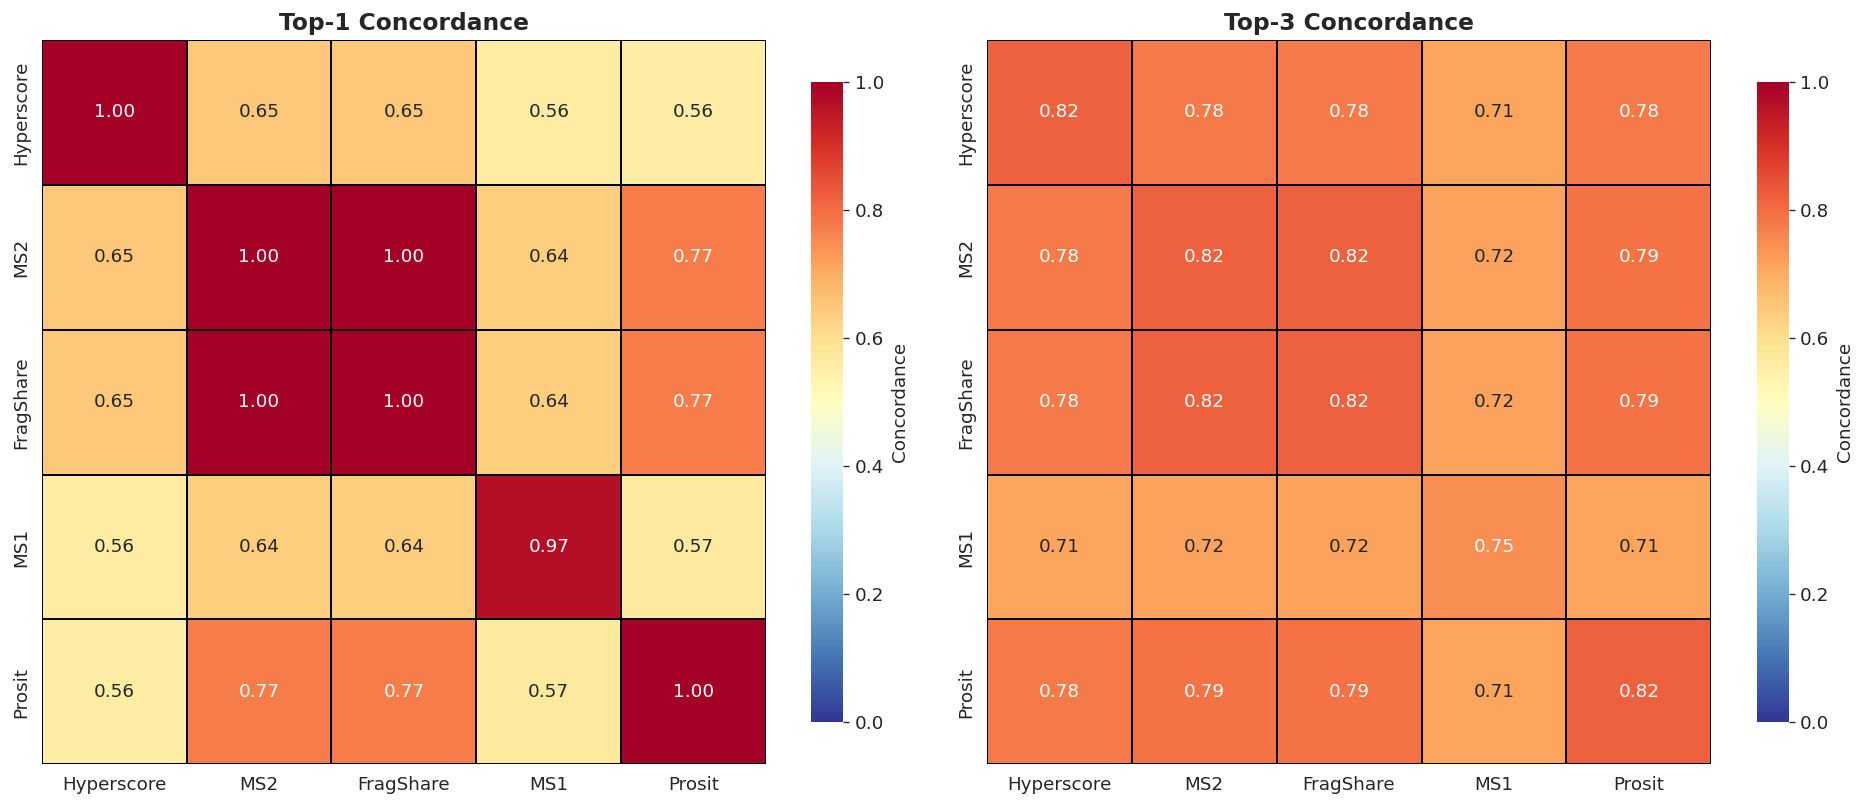

In [38]:
# ============================================================
# PLOT: Concordance Heatmaps
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, conc, title in zip(axes, [conc_top1, conc_top3], ['Top-1', 'Top-3']):
    sns.heatmap(conc, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0.5,
                square=True, ax=ax, vmin=0, vmax=1,
                cbar_kws={'shrink': 0.8, 'label': 'Concordance'},
                linewidths=1, linecolor='black')
    ax.set_title(f'{title} Concordance', fontweight='bold', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.savefig(PLOT_DIR / 'concordance_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# ============================================================
# CONCORDANCE BY WINDOW × COMPLEXITY
# ============================================================

from os import cpu_count
import subprocess
from pathlib import Path

print("\n" + "="*70)
print("CONCORDANCE BY WINDOW × COMPLEXITY")
print("="*70)

subsets_info = []
for window in ['narrow', 'medium', 'wide']:
    for n_psm in [2, 3, 4, 5]:
        subset = df_chimeric[(df_chimeric['window_category']==window) & 
                             (df_chimeric['n_psm']==n_psm)]
        n_spec = subset['spectrum_key'].nunique()
        if n_spec >= 10:
            subsets_info.append((window, n_psm, subset))

print(f"Processing {len(subsets_info)} subsets...")

if len(subsets_info) == 0:
    print("✗ No valid subsets found (all have <10 spectra)")
else:
    def calc_subset_concordances(args):
        window, n_psm, subset = args
        conc_hs_ms1_t1, n_spec = calc_concordance(subset, 'rank_hs', 'rank_ms1', 1)
        conc_hs_ms1_t3, _ = calc_concordance(subset, 'rank_hs', 'rank_ms1', 3)
        conc_hs_fragshare_t1, _ = calc_concordance(subset, 'rank_hs', 'rank_fragshare', 1)
        
        return {
            'window': window,
            'n_psm': n_psm,
            'n_spectra': n_spec,
            'HS_vs_MS1_top1': conc_hs_ms1_t1,
            'HS_vs_MS1_top3': conc_hs_ms1_t3,
            'HS_vs_FragShare_top1': conc_hs_fragshare_t1
        }

    n_cores = min(cpu_count(), len(subsets_info))
    with Pool(n_cores) as pool:
        results_cross = list(tqdm(pool.imap(calc_subset_concordances, subsets_info), 
                                 total=len(subsets_info), desc="Window×Complexity"))

    df_cross = pd.DataFrame(results_cross)
    print("\nConcordance by Window × Complexity:")
    print(df_cross.round(3).to_string(index=False))

    df_cross.to_csv(DATA_DIR / 'concordance_window_npsm.csv', index=False)
    print("\n✓ Saved")


CONCORDANCE BY WINDOW × COMPLEXITY
Processing 12 subsets...


NameError: name 'Pool' is not defined

In [ ]:
# ============================================================
# PLOT: Concordance vs Complexity
# ============================================================
if 'df_cross' in locals() and len(df_cross) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    for window, color in zip(['narrow', 'medium', 'wide'], 
                             ['#3498db', '#f39c12', '#e74c3c']):
        subset = df_cross[df_cross['window']==window]
        if len(subset) > 0:
            ax.plot(subset['n_psm'], subset['HS_vs_MS1_top1'], 'o-', 
                    color=color, lw=2, ms=8, label=window.capitalize())

    ax.set_xlabel('#PSMs per Spectrum', fontweight='bold', fontsize=12)
    ax.set_ylabel('Top-1 Concordance (HS vs MS1)', fontweight='bold', fontsize=12)
    ax.set_title('Concordance Decreases with Complexity', fontweight='bold', fontsize=14)
    ax.set_xticks([2, 3, 4, 5])
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
    ax.legend(title='Window')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOT_DIR / 'concordance_vs_complexity.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping plot - no valid window×complexity data")

In [ ]:
# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*70)
print("CONCORDANCE ANALYSIS COMPLETE")
print("="*70)

if 'conc_top1' in locals():
    print(f"""
Dataset:
  Total PSMs: {len(df):,}
  Chimeric PSMs: {len(df_chimeric):,}
  Chimeric spectra: {df_chimeric['spectrum_key'].nunique():,}

Matrix size: {len(conc_top1)}×{len(conc_top1)} ({len(conc_top1)**2} pairs)

Key Findings (Top-1):
  HS vs MS1: {conc_top1.loc['Hyperscore', 'MS1']:.3f}
  HS vs FragShare: {conc_top1.loc['Hyperscore', 'FragShare']:.3f}
  HS vs Prosit: {conc_top1.loc['Hyperscore', 'Prosit']:.3f}
  MS1 vs FragShare: {conc_top1.loc['MS1', 'FragShare']:.3f}

Output Files:
  {DATA_DIR / 'concordance_top1.csv'}
  {DATA_DIR / 'concordance_top3.csv'}
  {DATA_DIR / 'tie_analysis.csv'}
""")
    
    if 'df_cross' in locals():
        print(f"  {DATA_DIR / 'concordance_window_npsm.csv'}")

print("="*70)